---
#PCS 5787 Ciência dos Dados e Big Data

# **Projeto**


**Alunos**

Adriana Leticia dos Reis - **NUSP:** 8114620

Romeo Bulla Junior - **NUSP:** 5740440

---

<br>

**WHO-ONT**

Base de dados global do Observatório Global sobre **Doação e Transplante** (**GODT** - Global Observatory on Donation and Transplantation), conjunto da Organização Mundial da Saúde (OMS, em inglês, **WHO** World Health Organization) e da Organização Nacional de Transplantes espanhola (**ONT** - Transplant Organization). Acordo assinado em 22/12/2005.

<br>


# Libraries

In [90]:
%%capture
!pip install --upgrade pandas
!pip install openpyxl
!pip install unidecode

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd

# Show all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# retira acento
from unidecode import unidecode

import warnings
warnings.filterwarnings('ignore')



In [92]:
print(pd.__version__)

2.3.3


In [93]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True, readonly=True)

Mounted at /content/drive


In [94]:
path_file = '/content/drive/MyDrive/Doutorado - PCS 5787 Ciência dos Dados e Big Data/Projeto'

# Read datasets

In [95]:
# Transplants
df_godt = pd.read_excel(f'{path_file}/GODT_downloads.xlsx',
                       engine='openpyxl',
                       sheet_name='Database')
# df_godt.head()

In [96]:
# IDH
cols_read = 'A,B,K,M,O,Q'

df_IDH = pd.read_excel(f'{path_file}/HDR25_Statistical_Annex_Tables_1-7.xlsx',
                       engine='openpyxl',
                       sheet_name='Table 2. HDI trends',
                       skiprows=4,
                       usecols=cols_read
                       )


# Data clean - GODT

In [97]:
# Sort by Year/Country
df = df_godt.sort_values(by=['REPORTYEAR', 'COUNTRY']).reset_index(drop=True)
df.rename(columns={'REGION': 'region', 'COUNTRY': 'country', 'REPORTYEAR': 'year', 'POPULATION': 'population' }, inplace=True)

df['population'] = [str(x).replace(',','') for x in df['population']]

df['population'] = df['population'].astype(float)

# por milhao
# df['population_mm'] = df['population'] * 1000000

df = df[df['country'] != 'Monaco'].copy()

# df.head()

## GODT - Rename some countries

In [98]:
df.loc[df['country'] == 'Libyan Arab Jamahiriya', 'country'] = 'Libya'


## GODT - Retira Acento

In [99]:
# df['country'] = df['country'].str.replace('ü', 'u')
# df["country"] =  df.country.str.replace('[^\x00-\x7F]','')

# Data clean - IDH

In [100]:
df_idh = df_IDH.copy()

df_idh.rename(columns={'Country': 'country'}, inplace=True)

df_idh['development'] = None

lst = ['Very high human development', 'High human development', 'Medium human development', 'Low human development', 'Other countries or territories']

df_idh.loc[1:74, 'development'] = lst[0]
df_idh.loc[76:125, 'development'] = lst[1]
df_idh.loc[126:169, 'development'] = lst[2]
df_idh.loc[171:196, 'development'] = lst[3]
df_idh.loc[198:199, 'development'] = lst[4]

# Somente países com IDH rank
df_idh = df_idh.iloc[1:197]

df_idh = df_idh[~df_idh['country'].isin(lst)].sort_values(by='HDI rank')

# clean year
vars_idh =[2020,	2021,	2022,	2023]
for i in vars_idh:
  df_idh[i] = [str(x).replace('..','') for x in df_idh[i]]
  df_idh[i] = df_idh[i].replace(['', ''], pd.NA)
  df_idh[i] = pd.to_numeric(df_idh[i], errors='coerce')

  df_idh[i] = df_idh[i].astype(float)

# sort values
df_idh = df_idh.sort_values(by='country').reset_index(drop=True)

# df_idh[df_idh['Country'].isin(['Iceland','Bosnia and Herzegovina', 'Iran (Islamic Republic of)', 'Nauru', 'Bhutan', 'Lesotho', 'Pakistan', 'South Sudan', "Korea (Democratic People's Rep. of)", 'Monaco'])].sort_values(by='HDI rank')

# df_idh[df_idh['country'].isin(['South Africa'])].sort_values(by='HDI rank')
# display(df_idh.head())
# display(df_idh.tail())

## IDH - Pivot dataframe to transform column in row

In [101]:
df_idh = df_idh.melt(id_vars=['country', 'development'], var_name='year', value_name='idh')

# Retira as linhas que ficaram com o valor HDI rank, pois o rank é apenas um numero que representa em que posicao o país está
df_idh = df_idh[~(df_idh['year'] == 'HDI rank')]

df_idh['year'] = df_idh['year'].astype(int)

df_idh = df_idh.sort_values(by=['country', 'year']).reset_index(drop=True)


## IDH - Rename some countries

In [102]:
df_idh.loc[df_idh['country'] == 'North Macedonia', 'country'] = 'Republic of North Macedonia'

df_idh.loc[df_idh['country'] == 'Czechia', 'country'] = 'Czech Republic'

df_idh.loc[df_idh['country'] == 'Tanzania (United Republic of)', 'country'] = 'United Republic of Tanzania'

df_idh.loc[df_idh['country'] == 'United States', 'country'] = 'United States of America'

df_idh.loc[df_idh['country'] == 'Moldova (Republic of)', 'country'] = 'Republic of Moldova'

df_idh.loc[df_idh['country'] == 'Korea (Republic of)', 'country'] = 'Republic of Korea'



# Missing values - GODT

In [103]:
features_with_missing_values = df_godt.columns[df_godt.isnull().any()]

print(f'GODT - Features com valores ausentes:')
for feature in features_with_missing_values:
    print(f'{feature}: {df_godt[feature].isnull().sum()} ')

GODT - Features com valores ausentes:
TOTAL Actual DD: 5 
Actual DBD: 5 
Actual DCD: 6 
Total Utilized DD: 3 
Utilized DBD: 3 
Utilized DCD: 5 
DD Kidney Tx: 5 
LD Kidney Tx: 3 
TOTAL Kidney Tx: 3 
DD Liver Tx: 11 
DOMINO Liver Tx: 28 
LD Liver Tx: 14 
TOTAL Liver TX: 10 
Total Heart TX: 18 
DD Lung Tx: 23 
LD Lung Tx: 29 
TOTAL Lung Tx: 21 
Pancreas Tx: 23 
Kidney Pancreas Tx: 31 
Small Bowel Tx: 52 


#### Missing values per Country (Total Deceased Donors)


In [104]:
df.loc[df['TOTAL Actual DD'].isnull()]

,region,country,year,population,TOTAL Actual DD,Actual DBD,Actual DCD,Total Utilized DD,Utilized DBD,Utilized DCD,DD Kidney Tx,LD Kidney Tx,TOTAL Kidney Tx,DD Liver Tx,DOMINO Liver Tx,LD Liver Tx,TOTAL Liver TX,Total Heart TX,DD Lung Tx,LD Lung Tx,TOTAL Lung Tx,Pancreas Tx,Kidney Pancreas Tx,Small Bowel Tx
94,Europe,Albania,2021,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,America,Nicaragua,2021,6.7,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,America,Canada,2022,38.4,NaN,NaN,NaN,823.0,561.0,262.0,1310.0,485.0,1795.0,508.0,NaN,91.0,599.0,153.0,352.0,0.0,352.0,60.0,44.0,7.0
291,America,Canada,2023,38.8,NaN,NaN,NaN,952.0,638.0,314.0,1567.0,511.0,2078.0,583.0,NaN,86.0,669.0,184.0,450.0,0.0,450.0,66.0,47.0,7.0
383,America,Canada,2024,39.1,NaN,NaN,NaN,894.0,573.0,321.0,1438.0,491.0,1929.0,556.0,NaN,99.0,655.0,166.0,416.0,0.0,416.0,74.0,52.0,3.0


### Tratamento para o país Canada na variavel TOTAL Actual DD

*   List item
*   List item



Para preenchcer a variável TOTAL Actual DD, será utilizada variável **Total Utilized DD** pois o preenchimento está igual aos anos anteriores

Para preencher as variáveis **Actual DBD** e **Actual DCD** será utilizada a proporção de 70% e 30% (igual aos anos anteriores)



In [105]:
df.loc[(df['TOTAL Actual DD'].isnull()) & (df['Total Utilized DD'].notnull())]

,region,country,year,population,TOTAL Actual DD,Actual DBD,Actual DCD,Total Utilized DD,Utilized DBD,Utilized DCD,DD Kidney Tx,LD Kidney Tx,TOTAL Kidney Tx,DD Liver Tx,DOMINO Liver Tx,LD Liver Tx,TOTAL Liver TX,Total Heart TX,DD Lung Tx,LD Lung Tx,TOTAL Lung Tx,Pancreas Tx,Kidney Pancreas Tx,Small Bowel Tx
200,America,Canada,2022,38.4,NaN,NaN,NaN,823.0,561.0,262.0,1310.0,485.0,1795.0,508.0,NaN,91.0,599.0,153.0,352.0,0.0,352.0,60.0,44.0,7.0
291,America,Canada,2023,38.8,NaN,NaN,NaN,952.0,638.0,314.0,1567.0,511.0,2078.0,583.0,NaN,86.0,669.0,184.0,450.0,0.0,450.0,66.0,47.0,7.0
383,America,Canada,2024,39.1,NaN,NaN,NaN,894.0,573.0,321.0,1438.0,491.0,1929.0,556.0,NaN,99.0,655.0,166.0,416.0,0.0,416.0,74.0,52.0,3.0


In [106]:
# Total de Doadores falecidos é igual ao total de doadores Utlizados
df.loc[df['TOTAL Actual DD'].isnull(),'TOTAL Actual DD'] = df['Utilized DBD'] + df['Utilized DCD']

df.loc[(df['country'] == 'Canada') & (df['year'] > 2021) , 'Actual DBD'  ] = df['TOTAL Actual DD'] * 0.7
df.loc[(df['country'] == 'Canada') & (df['year'] > 2021)  , 'Actual DCD' ] = df['TOTAL Actual DD'] * 0.3

### Analysis to impute NaN with the mean or median



In [107]:
# Choose only numeric columns
numerics_type = ['float64']
numeric_columns = df.select_dtypes(include=numerics_type).columns.tolist()

df_aggregated = df.groupby('country')[numeric_columns].agg(['mean', 'median']).reset_index()

# rename columns
df_aggregated.columns = ['{}_{}'.format(col[0], col[1]) for col in df_aggregated.columns]
# df_aggregated.head()

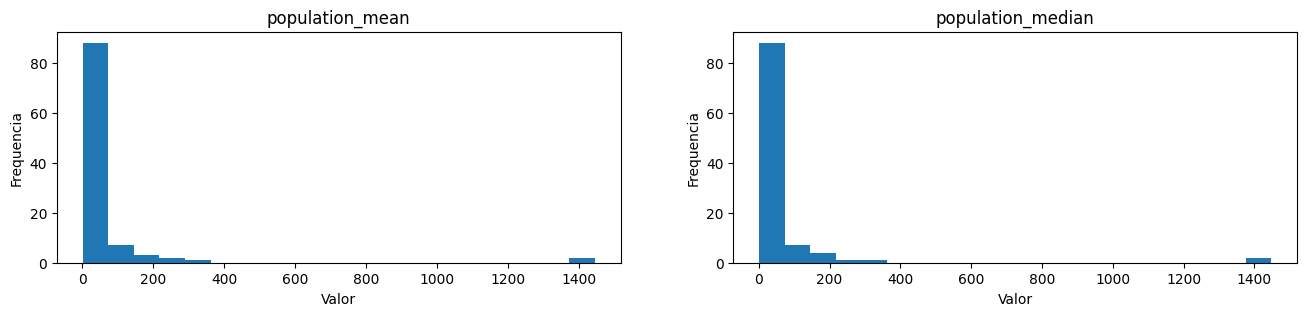

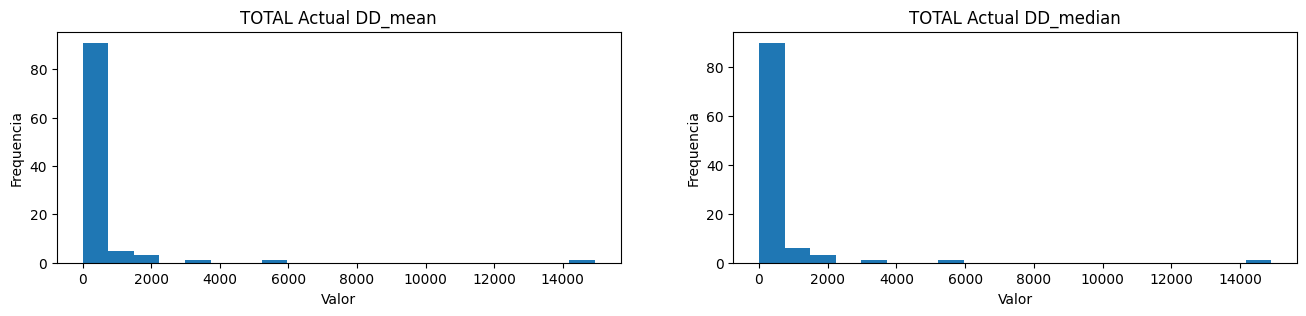

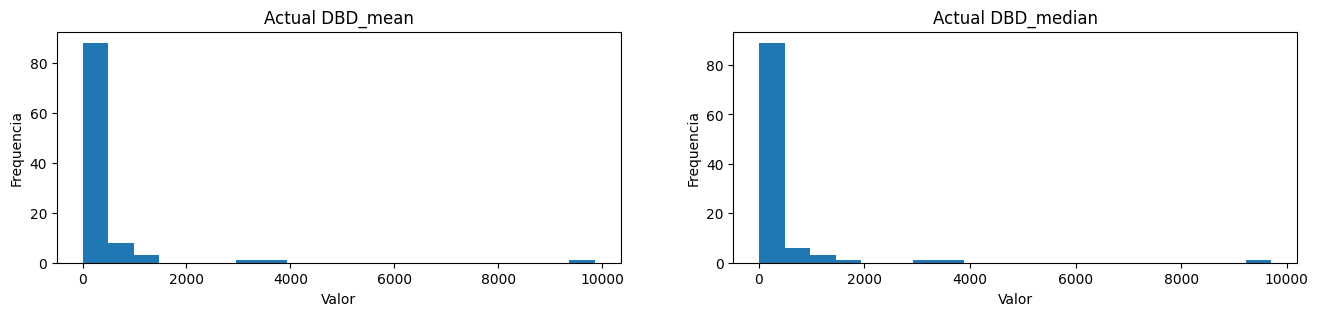

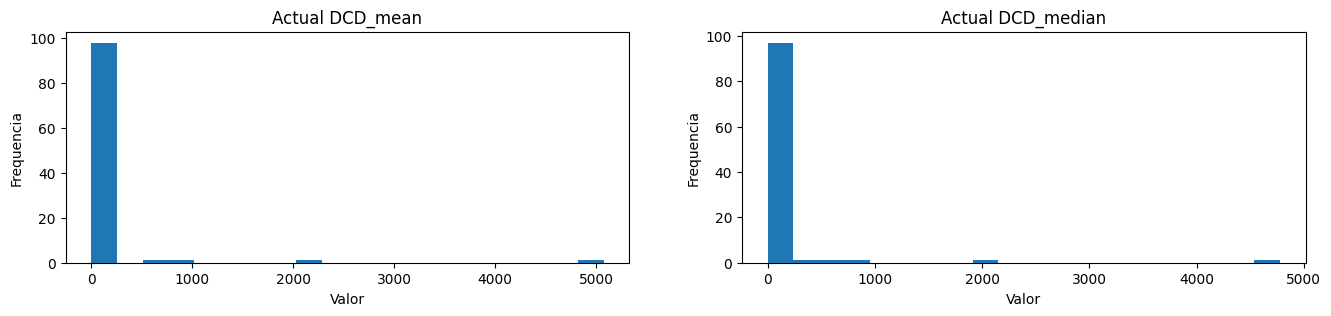

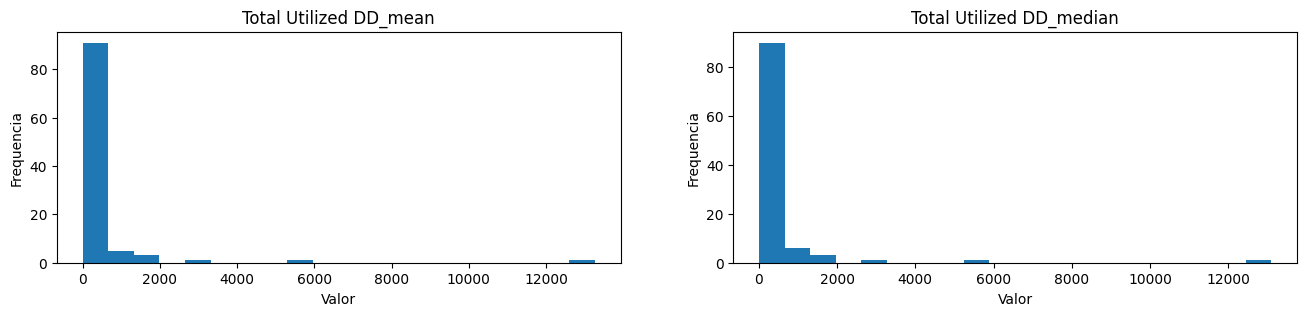

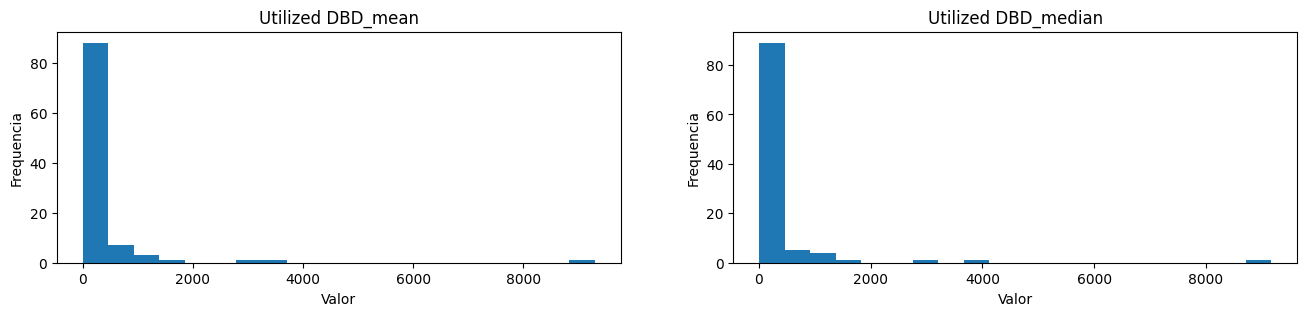

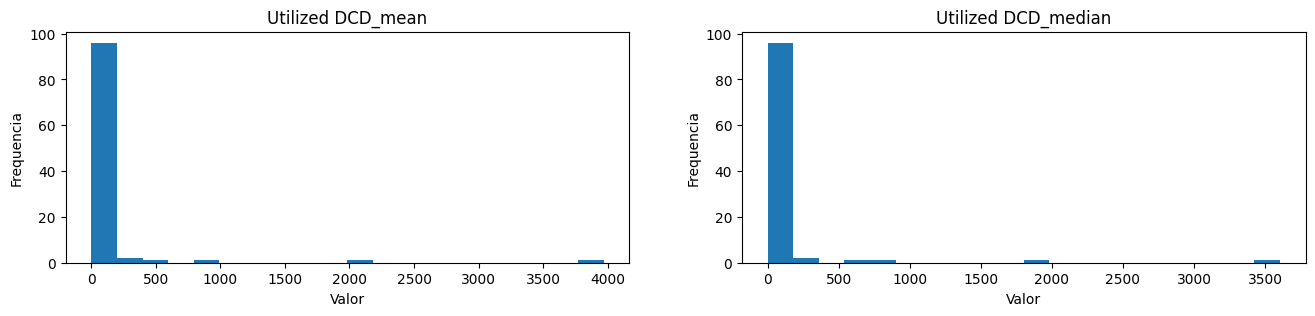

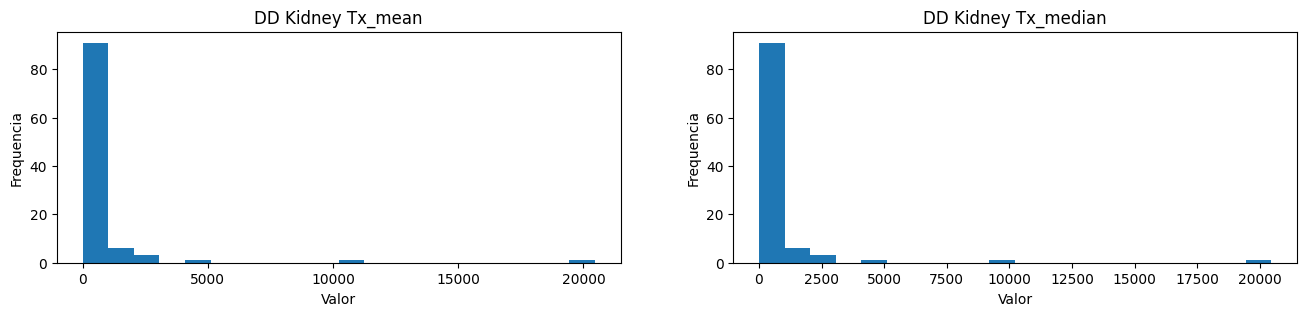

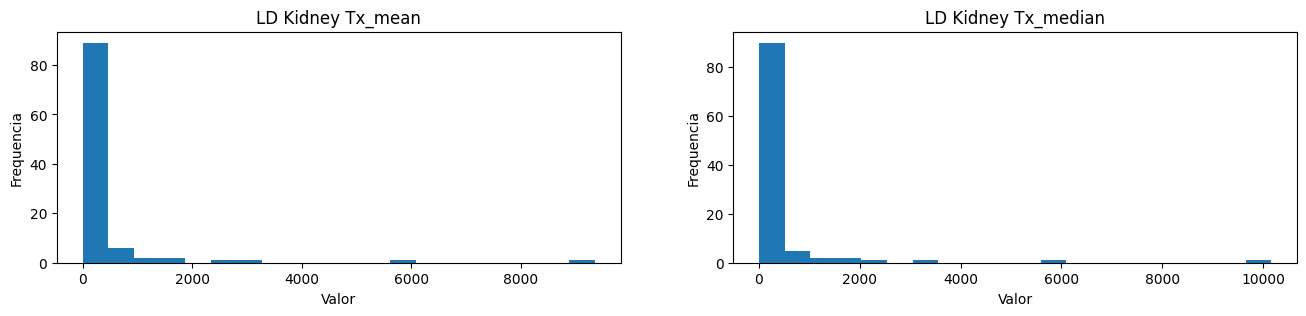

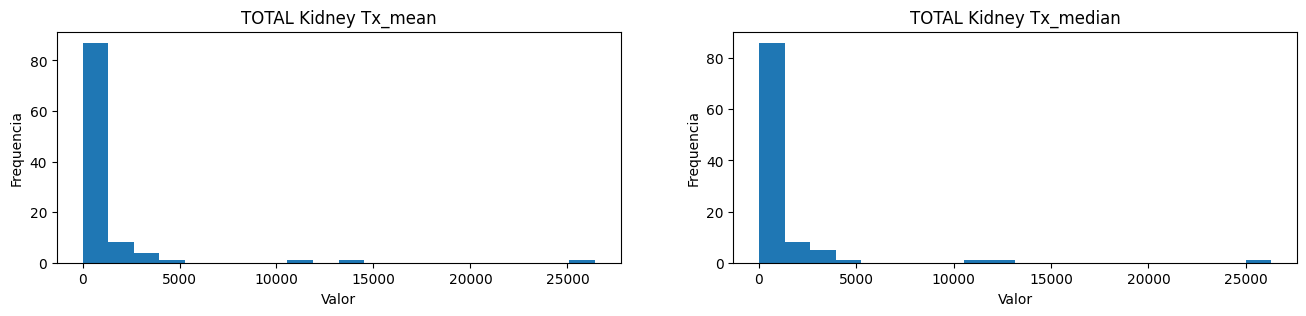

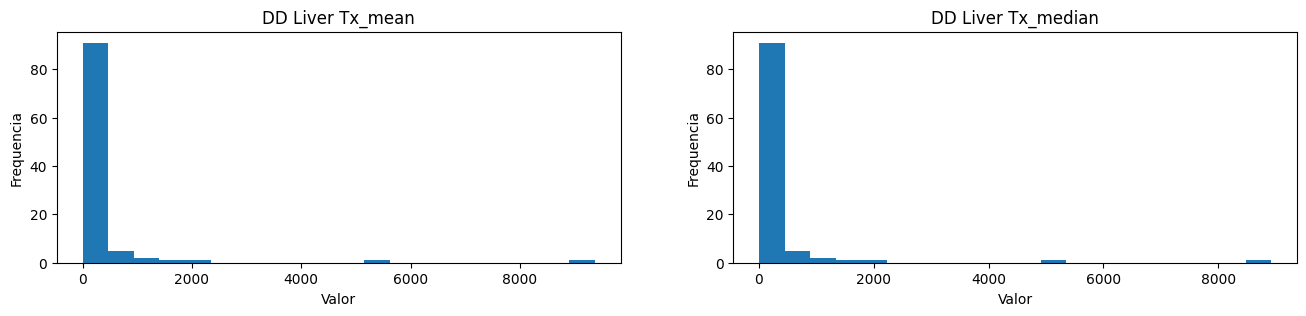

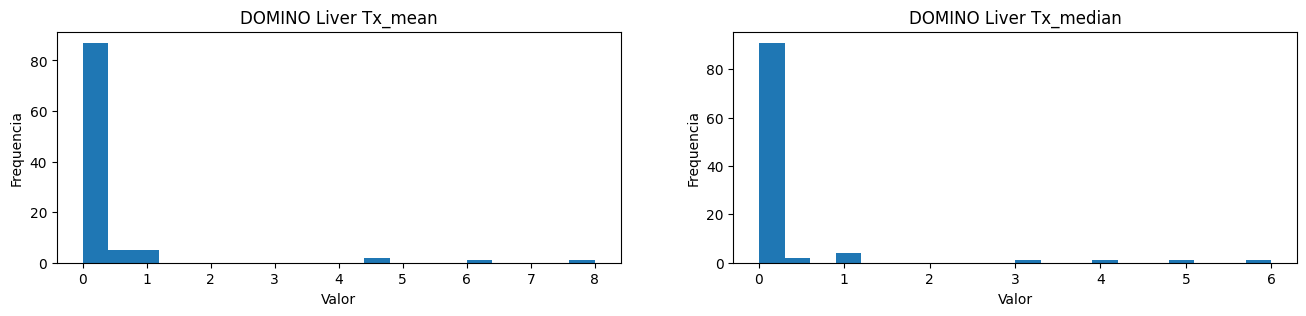

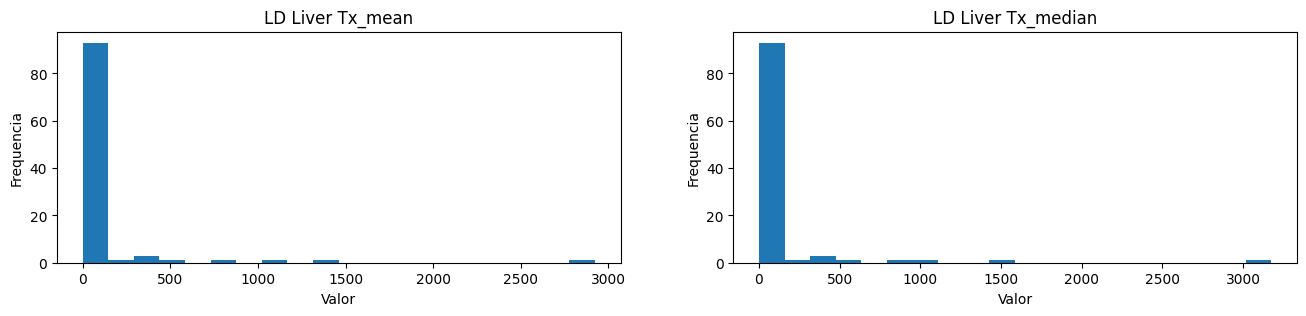

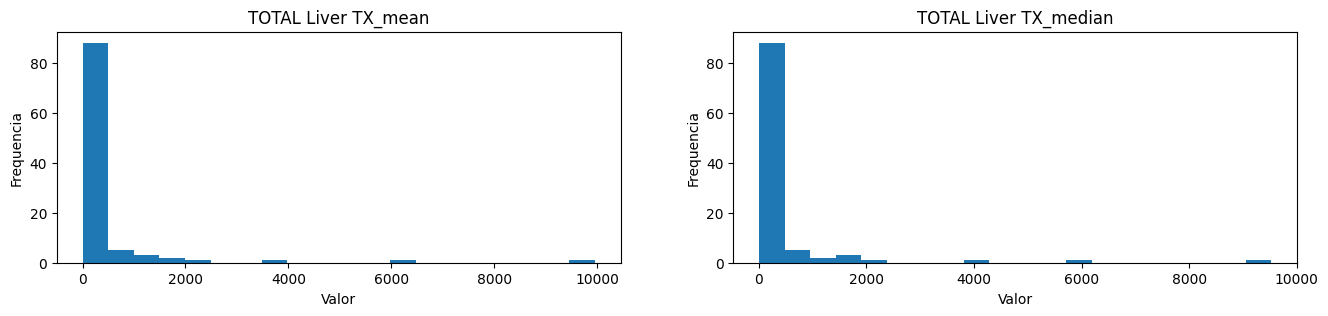

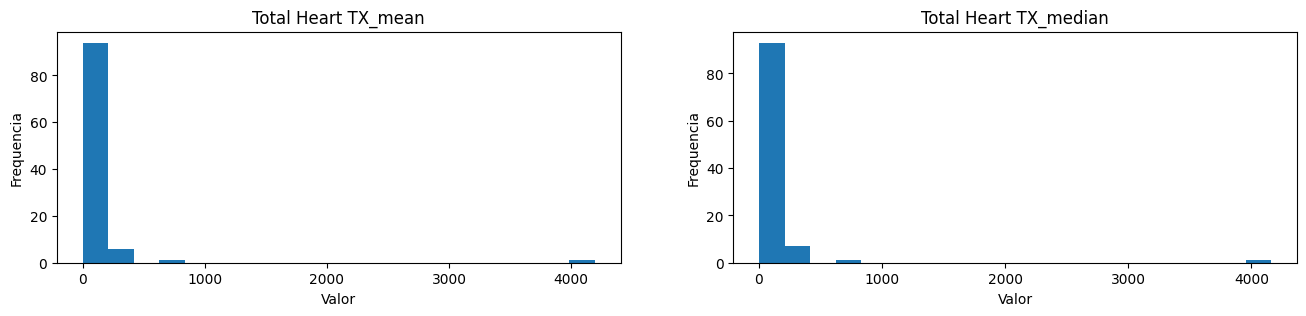

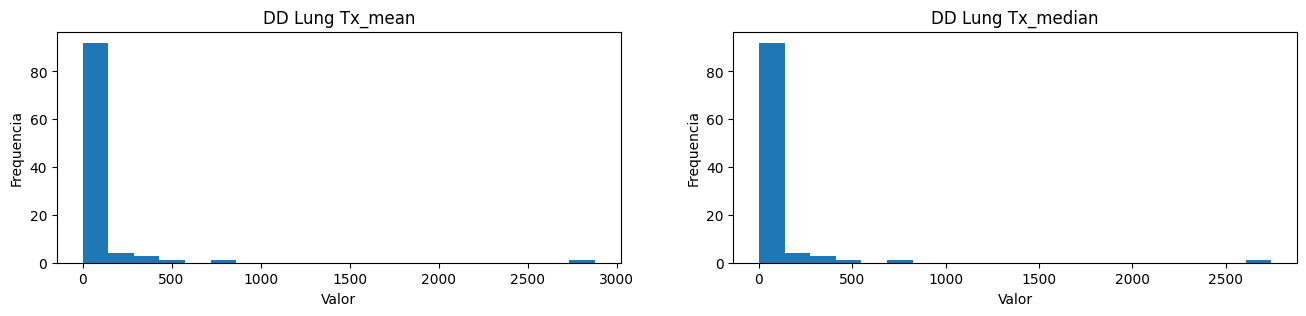

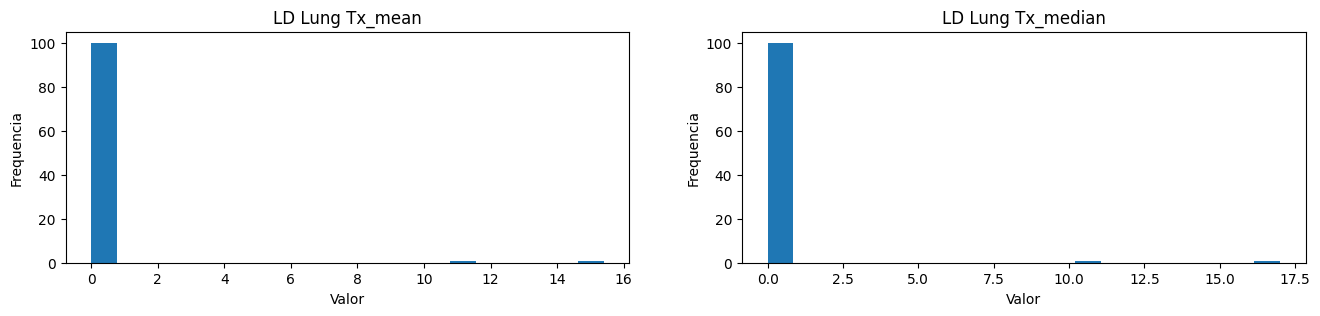

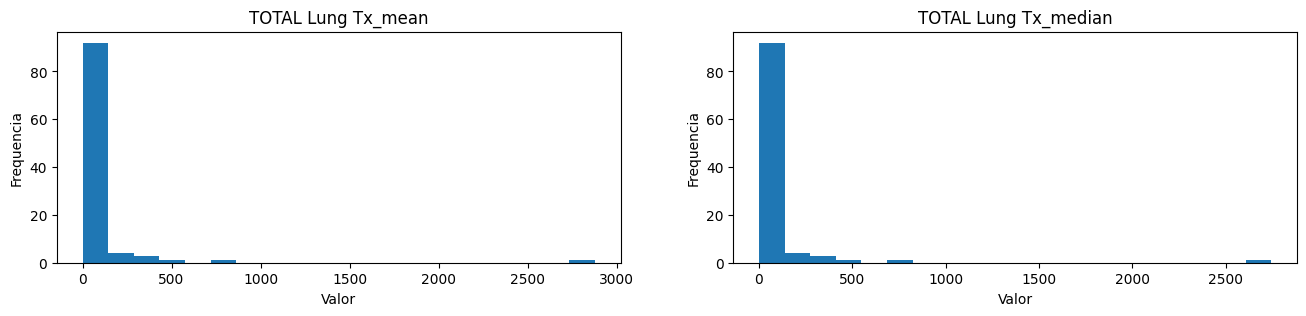

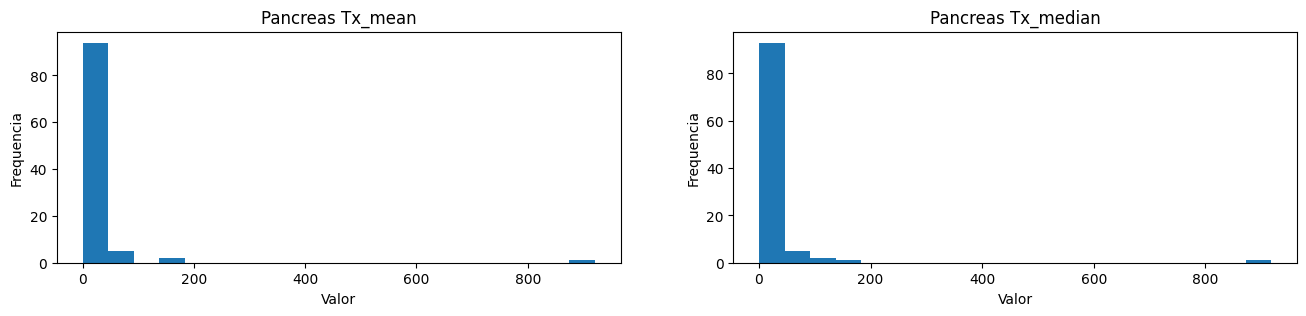

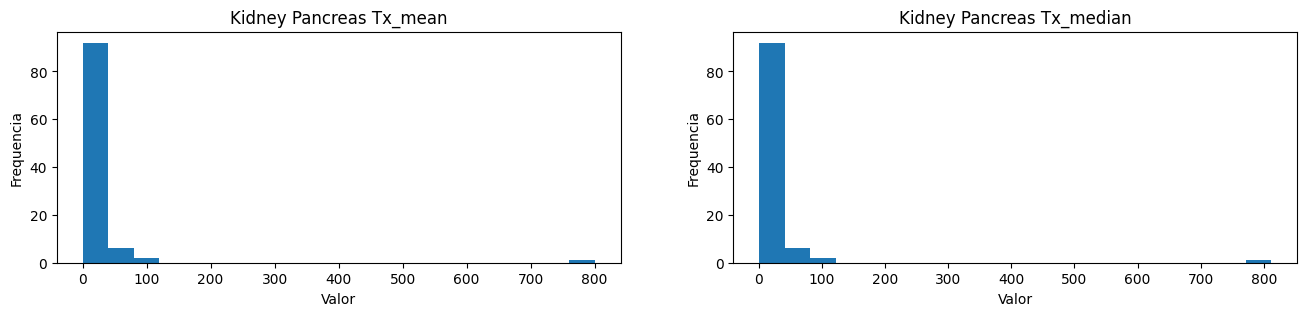

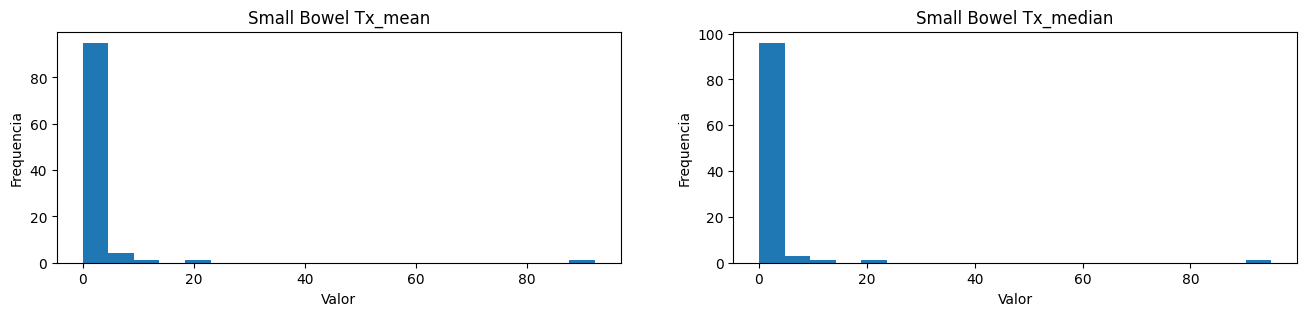

In [108]:
cols = df_aggregated.select_dtypes(include=numerics_type).columns.tolist()

for i in range(0, len(cols), 2):
  col_pair = cols[i:i+2]
  # print(col_pair)
  fig, axes = plt.subplots(1, len(col_pair), figsize=(16,3))
  for ax, col in zip(axes, col_pair):
    ax.hist(df_aggregated[col], bins=20)
    ax.set_title(col)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequencia')

  #plt.tight_layout()
  plt.show()




### Imput NaN values with median

In [109]:
numerics_type = ['float64']
numeric_columns = df.select_dtypes(include=numerics_type).columns.tolist()

for col in numeric_columns:
    # print(col)
    df[col] = df.groupby('country')[col].transform(lambda x: x.fillna(x.median())) # transform: retorna índice original (compatível para atribuição).

# Imput 0 para casos que não possui valor
df = df.fillna(0)


In [110]:
# display(df_aggregated[df_aggregated['country_'] == 'Iran (Islamic Republic of)'])
# display(df_godt[df_godt['COUNTRY'] == 'Iran (Islamic Republic of)'])
# display(df[df['country'] == 'Iran (Islamic Republic of)'])

# Missing values - IDH

In [111]:
features_with_missing_values = df_idh.columns[df_idh.isnull().any()]

print(f'IDH - Features com valores ausentes:')
for feature in features_with_missing_values:
    print(f'{feature}: {df_idh[feature].isnull().sum()} ')

IDH - Features com valores ausentes:
idh: 3 


# Create vars - IDH


In [112]:
df['TOTAL tx'] = df['TOTAL Kidney Tx'] + df['TOTAL Liver TX'] + df['Total Heart TX'] + df['TOTAL Lung Tx'] + df['Pancreas Tx'] + df['Small Bowel Tx']

# EDA

## GODT - Total features and rows

In [113]:
#Get overview of the data
def dataoveriew(df, message):
    print(f'{message}\n')
    print('Number of rows: ', df.shape[0])
    print(f'\nNumber of features:', df.shape[1])
    print(f'\nData Features:')
    print(df.columns.tolist())
    print(f'\nMissing values:', df.isnull().sum().values.sum())
    print(f'\nUnique values:')
    print(df.nunique())

dataoveriew(df, 'Overview of the GODT dataset')

Overview of the GODT dataset

Number of rows:  461

Number of features: 25

Data Features:
['region', 'country', 'year', 'population', 'TOTAL Actual DD', 'Actual DBD', 'Actual DCD', 'Total Utilized DD', 'Utilized DBD', 'Utilized DCD', 'DD Kidney Tx', 'LD Kidney Tx', 'TOTAL Kidney Tx', 'DD Liver Tx', 'DOMINO Liver Tx', 'LD Liver Tx', 'TOTAL Liver TX', 'Total Heart TX', 'DD Lung Tx', 'LD Lung Tx', 'TOTAL Lung Tx', 'Pancreas Tx', 'Kidney Pancreas Tx', 'Small Bowel Tx', 'TOTAL tx']

Missing values: 0

Unique values:
region                  6
country               103
year                    5
population            255
TOTAL Actual DD       228
Actual DBD            219
Actual DCD             89
Total Utilized DD     221
Utilized DBD          210
Utilized DCD           82
DD Kidney Tx          252
LD Kidney Tx          232
TOTAL Kidney Tx       311
DD Liver Tx           199
DOMINO Liver Tx        13
LD Liver Tx           107
TOTAL Liver TX        218
Total Heart TX        143
DD Lung Tx    

## IDH - Total features and rows

In [114]:
dataoveriew(df_idh, 'Overview of IDH dataset')

Overview of IDH dataset

Number of rows:  772

Number of features: 4

Data Features:
['country', 'development', 'year', 'idh']

Missing values: 3

Unique values:
country        193
development      4
year             4
idh            401
dtype: int64


## GODT - Data type

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461 entries, 0 to 461
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              461 non-null    object 
 1   country             461 non-null    object 
 2   year                461 non-null    int64  
 3   population          461 non-null    float64
 4   TOTAL Actual DD     461 non-null    float64
 5   Actual DBD          461 non-null    float64
 6   Actual DCD          461 non-null    float64
 7   Total Utilized DD   461 non-null    float64
 8   Utilized DBD        461 non-null    float64
 9   Utilized DCD        461 non-null    float64
 10  DD Kidney Tx        461 non-null    float64
 11  LD Kidney Tx        461 non-null    float64
 12  TOTAL Kidney Tx     461 non-null    float64
 13  DD Liver Tx         461 non-null    float64
 14  DOMINO Liver Tx     461 non-null    float64
 15  LD Liver Tx         461 non-null    float64
 16  TOTAL Liver T

## IDH - Data type

In [116]:
df_idh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      772 non-null    object 
 1   development  772 non-null    object 
 2   year         772 non-null    int64  
 3   idh          769 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 24.3+ KB


## Countries - GODT


In [117]:
# sorted(df_godt['COUNTRY'].unique())
df['country'].unique()

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Bangladesh', 'Belarus', 'Belgium',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador',
       'Estonia', 'Ethiopia', 'Finland', 'France', 'Georgia', 'Germany',
       'Greece', 'Guatemala', 'Hungary', 'Iceland', 'India',
       'Iran (Islamic Republic of)', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico',
       'Mongolia', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria',
       'Norway', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Republic of Korea',
       'Republic of Moldova', 'Republic of North Macedonia', 

## Countries - IDH

In [118]:
df_idh['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo',
       'Congo (Democratic Republic of the)', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini (Kingdom of)', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece'

## Describe - GODT

In [119]:
df[numeric_columns].describe().applymap('{:,.0f}'.format)

,population,TOTAL Actual DD,Actual DBD,Actual DCD,Total Utilized DD,Utilized DBD,Utilized DCD,DD Kidney Tx,LD Kidney Tx,TOTAL Kidney Tx,DD Liver Tx,DOMINO Liver Tx,LD Liver Tx,TOTAL Liver TX,Total Heart TX,DD Lung Tx,LD Lung Tx,TOTAL Lung Tx,Pancreas Tx,Kidney Pancreas Tx,Small Bowel Tx
count,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461,461
mean,66,454,343,110,422,326,96,678,400,"1,078",314,0,95,409,100,76,0,76,22,19,2
std,211,"1,713","1,157",598,"1,545","1,093",489,"2,448","1,253","3,302","1,157",1,380,"1,311",448,317,2,317,98,85,10
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,5,2,2,0,2,2,0,3,10,35,0,0,0,1,0,0,0,0,0,0,0
50%,10,47,45,0,44,44,0,70,52,171,21,0,1,30,6,1,0,1,0,0,0
75%,45,222,177,1,206,165,1,327,222,526,145,0,20,188,49,34,0,34,13,10,0
max,"1,457","16,989","10,441","7,283","14,908","9,809","5,741","22,074","11,791","28,493","10,854",14,"3,946","11,458","4,636","3,404",19,"3,404",963,827,97


## Describe - IDH

In [120]:
df_idh.describe()

,year,idh
count,772.000000,769.000000
mean,2021.500000,0.734576
std,1.118759,0.149971
min,2020.000000,0.339000
25%,2020.750000,0.617000
50%,2021.500000,0.754000
75%,2022.250000,0.852000
max,2023.000000,0.972000


## Frequency categoric vars - GODT

In [121]:
df.describe(include=['O'])

,region,country
count,461,461
unique,6,103
top,Europe,Albania
freq,214,5


## Frequency categoric vars - IDH

In [122]:
df_idh.describe(include=['O'])

,country,development
count,772,772
unique,193,4
top,Afghanistan,Very high human development
freq,4,296


# Merge

In [123]:
df_final = df.merge(df_idh, on=['country', 'year'], how='left')

## Check df_final IDH null values

In [124]:
df_final.loc[
    (df_final['year'].isin([2020, 2021, 2022, 2023])) &
    (df_final['idh'].isnull()),
    ['country', 'year','idh']
].sort_values(by='country')

,country,year,idh
85,Türkiye,2020,NaN
179,Türkiye,2021,NaN
270,Türkiye,2022,NaN
362,Türkiye,2023,NaN


In [125]:
df_final.loc[(df_final['development'].isnull()) & (df_final['year'] != 2024)]

,region,country,year,population,TOTAL Actual DD,Actual DBD,Actual DCD,Total Utilized DD,Utilized DBD,Utilized DCD,DD Kidney Tx,LD Kidney Tx,TOTAL Kidney Tx,DD Liver Tx,DOMINO Liver Tx,LD Liver Tx,TOTAL Liver TX,Total Heart TX,DD Lung Tx,LD Lung Tx,TOTAL Lung Tx,Pancreas Tx,Kidney Pancreas Tx,Small Bowel Tx,TOTAL tx,development,idh
85,Europe,Türkiye,2020,84.3,172.0,172.0,0.0,148.0,148.0,0.0,249.0,2249.0,2498.0,129.0,2.0,1189.0,1320.0,21.0,11.0,0.0,11.0,1.0,0.0,2.0,3853.0,NaN,NaN
179,Europe,Türkiye,2021,85.0,305.0,305.0,0.0,165.0,165.0,0.0,298.0,3077.0,3375.0,141.0,2.0,1387.0,1528.0,24.0,21.0,0.0,21.0,0.0,0.0,2.0,4950.0,NaN,NaN
270,Europe,Türkiye,2022,85.6,289.0,289.0,0.0,176.0,176.0,0.0,281.0,3340.0,3621.0,148.0,10.0,1462.0,1610.0,26.0,11.0,0.0,11.0,0.0,0.0,2.0,5270.0,NaN,NaN
362,Europe,Türkiye,2023,85.8,305.0,305.0,0.0,190.0,190.0,0.0,301.0,3151.0,3452.0,156.0,12.0,1600.0,1768.0,40.0,15.0,0.0,15.0,1.0,0.0,1.0,5277.0,NaN,NaN


## Input value to Turkye country

In [126]:
df_final.loc[(df_final['country'].str.contains('rkiye')) & (df_final['year'] == 2020), 'idh'] = 0.838
df_final.loc[(df_final['country'].str.contains('rkiye')) & (df_final['year'] == 2021), 'idh'] = 0.841
df_final.loc[(df_final['country'].str.contains('rkiye')) & (df_final['year'] == 2022), 'idh'] = 0.853
df_final.loc[(df_final['country'].str.contains('rkiye')) & (df_final['year'] == 2023), 'idh'] = 0.853

df_final.loc[(df_final['country'].str.contains('rkiye')) , 'development'] = 'Very high human development'
# df_final[(df_final['country'].str.contains('rkiye')) ]

## Input null **idh** values for the year 2024 using the median.

In [127]:
df_final['idh'] = df_final.groupby('country')['idh'].transform(lambda x: x.fillna(x.median()))

df_final.loc[df_final['country'] == 'South Africa', 'idh'] = 0.731
# df_final[['country', 'year', 'idh']].loc[df_final['country'].isin(['Brazil', 'Canada', 'Iceland', 'Norway'])].sort_values(by=['country', 'year'])


## Input null **development** values for the year 2024 using the mode

In [128]:
df_final['development'] = df_final.groupby('country')['development'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))

df_final.loc[df_final['country'] == 'South Africa', 'development'] = 'High human development'


## Create vars pmp (per million population)

In [129]:
vars_pmp =['TOTAL tx', 'TOTAL Actual DD', 'Actual DBD', 'Actual DCD', 'Total Utilized DD', 'Utilized DBD', 'Utilized DCD', 'DD Kidney Tx', 'LD Kidney Tx', 'TOTAL Kidney Tx',
           'DD Liver Tx', 'DOMINO Liver Tx', 'LD Liver Tx', 'TOTAL Liver TX', 'Total Heart TX', 'DD Lung Tx', 'LD Lung Tx', 'TOTAL Lung Tx',
           'Pancreas Tx', 'Kidney Pancreas Tx', 'Small Bowel Tx']

for i in vars_pmp:
  df_final[f'pmp_{i}'] = df_final[i] / df_final['population']


## Describe dataframe final - Original vars

In [130]:
df_final[['TOTAL tx', 'pmp_TOTAL tx', 'TOTAL Kidney Tx', 'pmp_TOTAL Kidney Tx',
           'TOTAL Liver TX', 'pmp_TOTAL Liver TX', 'Total Heart TX', 'pmp_Total Heart TX', 'TOTAL Lung Tx', 'pmp_TOTAL Lung Tx',
           'Pancreas Tx', 'pmp_Pancreas Tx',  'Small Bowel Tx', 'pmp_Small Bowel Tx']].describe().T.style.bar(
    subset=['mean'],
    color='Reds').background_gradient(
    subset=['std'], cmap='ocean').background_gradient(subset=['50%'], cmap='plasma')

,count,mean,std,min,25%,50%,75%,max
TOTAL tx,461.000000,1686.888286,5398.830699,0.000000,46.000000,219.000000,872.000000,48935.000000
pmp_TOTAL tx,461.000000,31.050069,30.328577,0.000000,5.851064,18.648649,52.692308,143.168520
TOTAL Kidney Tx,461.000000,1078.049892,3302.390934,0.000000,35.000000,171.000000,526.000000,28493.000000
pmp_TOTAL Kidney Tx,461.000000,20.352840,18.248783,0.000000,4.860335,14.285714,34.316703,85.242105
TOTAL Liver TX,461.000000,408.570499,1310.638846,0.000000,1.000000,30.000000,188.000000,11458.000000
pmp_TOTAL Liver TX,461.000000,6.680724,8.039053,0.000000,0.084746,3.080808,10.776654,33.522528
Total Heart TX,461.000000,99.583514,447.536450,0.000000,0.000000,6.000000,49.000000,4636.000000
pmp_Total Heart TX,461.000000,1.897674,2.707262,0.000000,0.000000,0.415430,3.454545,13.809524
TOTAL Lung Tx,461.000000,76.449024,317.036289,0.000000,0.000000,1.000000,34.000000,3404.000000
pmp_TOTAL Lung Tx,461.000000,1.628201,2.767123,0.000000,0.000000,0.046048,2.195122,13.777778


## Info df_final

In [131]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   region                  461 non-null    object 
 1   country                 461 non-null    object 
 2   year                    461 non-null    int64  
 3   population              461 non-null    float64
 4   TOTAL Actual DD         461 non-null    float64
 5   Actual DBD              461 non-null    float64
 6   Actual DCD              461 non-null    float64
 7   Total Utilized DD       461 non-null    float64
 8   Utilized DBD            461 non-null    float64
 9   Utilized DCD            461 non-null    float64
 10  DD Kidney Tx            461 non-null    float64
 11  LD Kidney Tx            461 non-null    float64
 12  TOTAL Kidney Tx         461 non-null    float64
 13  DD Liver Tx             461 non-null    float64
 14  DOMINO Liver Tx         461 non-null    fl

In [132]:
df_final[['population', 'idh', 'TOTAL tx', 'TOTAL Actual DD', 'Actual DBD', 'Actual DCD', 'Total Utilized DD', 'Utilized DBD', 'Utilized DCD', 'DD Kidney Tx', 'LD Kidney Tx', 'TOTAL Kidney Tx',
           'DD Liver Tx', 'DOMINO Liver Tx', 'LD Liver Tx', 'TOTAL Liver TX', 'Total Heart TX', 'DD Lung Tx', 'LD Lung Tx', 'TOTAL Lung Tx',
           'Pancreas Tx', 'Kidney Pancreas Tx', 'Small Bowel Tx']].describe().T.style.bar(
    subset=['mean'],
    color='Reds').background_gradient(
    subset=['std'], cmap='ocean').background_gradient(subset=['50%'], cmap='plasma')

,count,mean,std,min,25%,50%,75%,max
population,461.000000,65.666377,211.074506,0.300000,4.800000,10.400000,45.200000,1456.800000
idh,461.000000,0.824326,0.111115,0.486000,0.770000,0.838000,0.916000,0.972000
TOTAL tx,461.000000,1686.888286,5398.830699,0.000000,46.000000,219.000000,872.000000,48935.000000
TOTAL Actual DD,461.000000,453.563991,1713.473985,0.000000,2.000000,47.000000,222.000000,16989.000000
Actual DBD,461.000000,343.106941,1157.396995,0.000000,2.000000,45.000000,177.000000,10441.000000
Actual DCD,461.000000,110.459219,597.867093,0.000000,0.000000,0.000000,1.000000,7283.000000
Total Utilized DD,461.000000,421.671367,1545.385305,0.000000,2.000000,44.000000,206.000000,14908.000000
Utilized DBD,461.000000,325.755965,1093.451716,0.000000,2.000000,44.000000,165.000000,9809.000000
Utilized DCD,461.000000,95.845987,488.653487,0.000000,0.000000,0.000000,1.000000,5741.000000
DD Kidney Tx,461.000000,678.143167,2447.755656,0.000000,3.000000,70.000000,327.000000,22074.000000


## Describe dataframe final - vars pmp

In [133]:
vars_pmp = ['pmp_TOTAL tx', 'pmp_TOTAL Actual DD', 'pmp_Actual DBD', 'pmp_Actual DCD', 'pmp_Total Utilized DD', 'pmp_Utilized DBD', 'pmp_Utilized DCD', 'pmp_DD Kidney Tx', 'pmp_LD Kidney Tx', 'pmp_TOTAL Kidney Tx', 'pmp_DD Liver Tx',
'pmp_DOMINO Liver Tx', 'pmp_LD Liver Tx', 'pmp_TOTAL Liver TX', 'pmp_Total Heart TX', 'pmp_DD Lung Tx', 'pmp_LD Lung Tx', 'pmp_TOTAL Lung Tx', 'pmp_Pancreas Tx', 'pmp_Kidney Pancreas Tx', 'pmp_Small Bowel Tx']

df_final[vars_pmp].describe().T.style.bar(
    subset=['mean'],
    color='Reds').background_gradient(
    subset=['std'], cmap='ocean').background_gradient(subset=['50%'], cmap='plasma')




,count,mean,std,min,25%,50%,75%,max
pmp_TOTAL tx,461.000000,31.050069,30.328577,0.000000,5.851064,18.648649,52.692308,143.168520
pmp_TOTAL Actual DD,461.000000,9.271005,10.836104,0.000000,0.303030,4.166667,17.034884,53.936842
pmp_Actual DBD,461.000000,7.967781,8.815153,0.000000,0.303030,4.120603,12.941176,36.666667
pmp_Actual DCD,461.000000,1.303271,3.534276,0.000000,0.000000,0.000000,0.065253,27.705263
pmp_Total Utilized DD,461.000000,8.809541,10.139497,0.000000,0.303030,4.120603,16.153846,47.957895
pmp_Utilized DBD,461.000000,7.623896,8.401301,0.000000,0.303030,4.090909,12.452107,36.666667
pmp_Utilized DCD,461.000000,1.184215,3.169335,0.000000,0.000000,0.000000,0.065253,24.189474
pmp_DD Kidney Tx,461.000000,13.572455,15.536976,0.000000,0.364583,6.593460,24.761905,76.863158
pmp_LD Kidney Tx,461.000000,6.780385,7.185916,0.000000,1.902439,4.700855,8.750000,39.018692
pmp_TOTAL Kidney Tx,461.000000,20.352840,18.248783,0.000000,4.860335,14.285714,34.316703,85.242105


# Charts

## Correlation matrix - original features

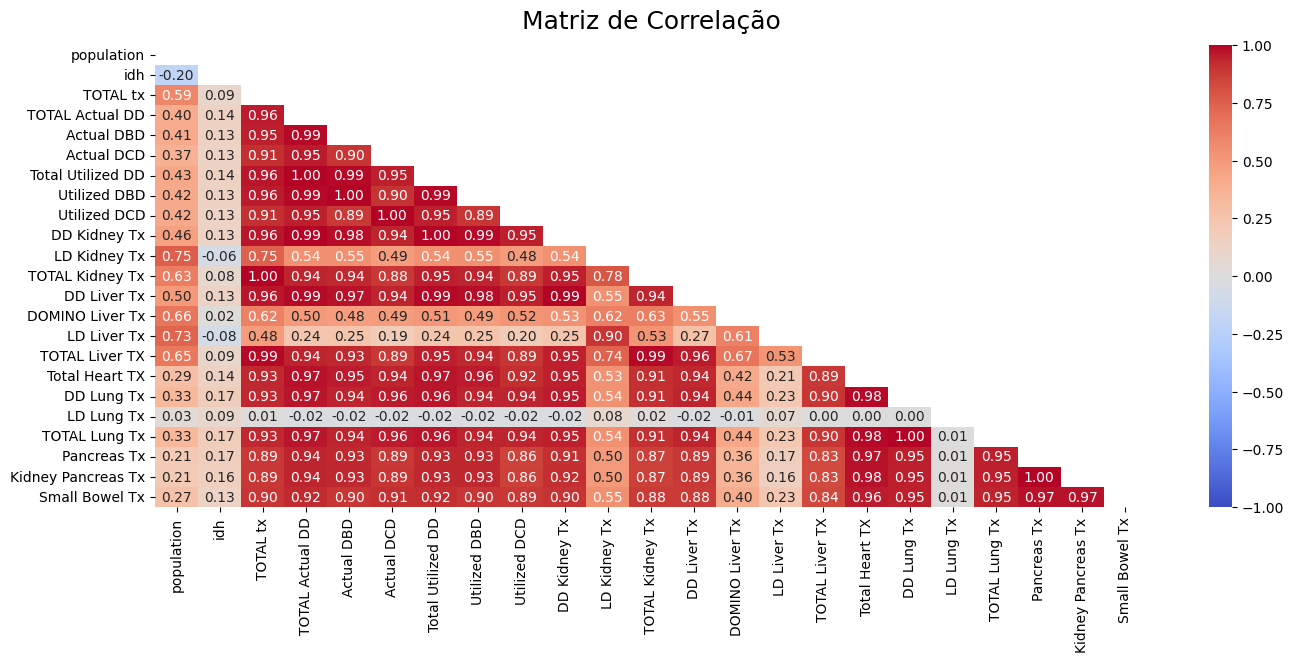

In [134]:
vars_corr =['population', 'idh', 'TOTAL tx','TOTAL Actual DD', 'Actual DBD', 'Actual DCD', 'Total Utilized DD', 'Utilized DBD', 'Utilized DCD', 'DD Kidney Tx', 'LD Kidney Tx', 'TOTAL Kidney Tx',
           'DD Liver Tx', 'DOMINO Liver Tx', 'LD Liver Tx', 'TOTAL Liver TX', 'Total Heart TX', 'DD Lung Tx', 'LD Lung Tx', 'TOTAL Lung Tx',
           'Pancreas Tx', 'Kidney Pancreas Tx', 'Small Bowel Tx']

# Compute the correlation matrix
corr = df_final[vars_corr].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,6))

heatmap = sns.heatmap(corr, cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",mask=mask)

heatmap.set_title('Matriz de Correlação', fontdict={'fontsize':18}, pad=12)
plt.show()

## Correlation matrix - pmp features

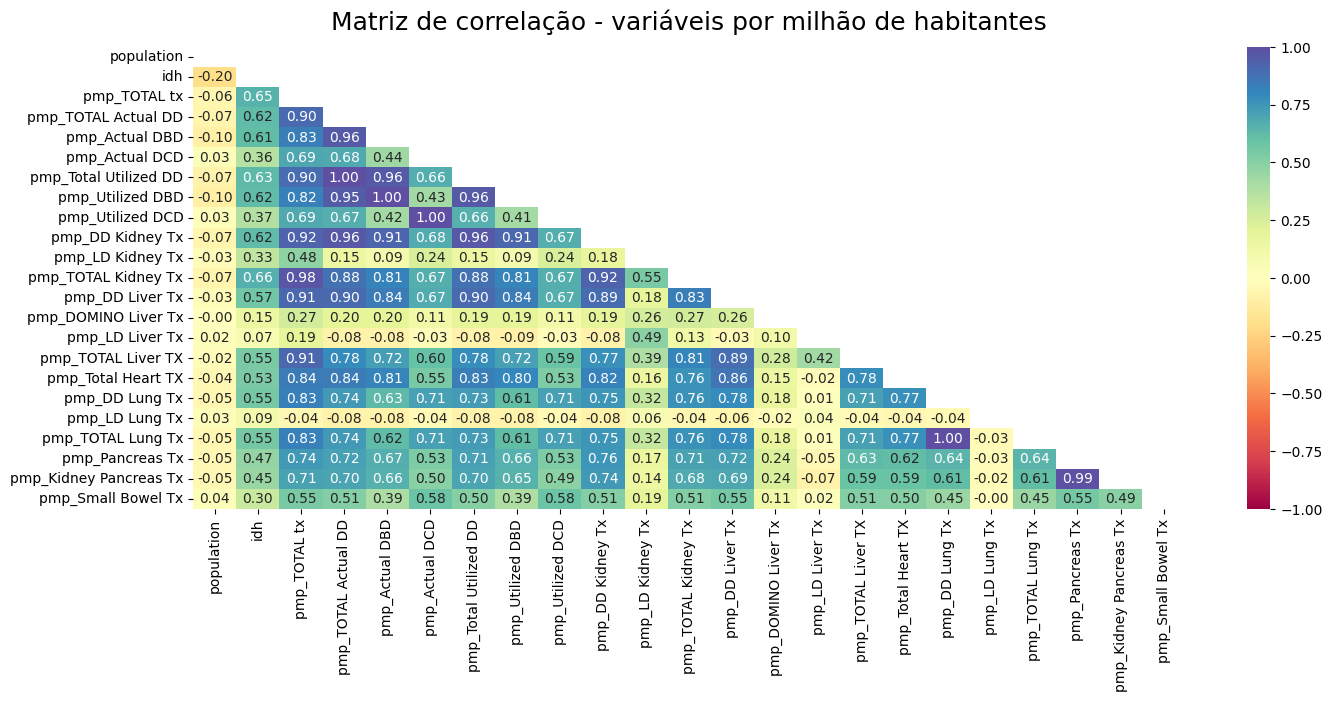

In [135]:
vars_corr =['population', 'idh', 'pmp_TOTAL tx', 'pmp_TOTAL Actual DD', 'pmp_Actual DBD', 'pmp_Actual DCD',
       'pmp_Total Utilized DD', 'pmp_Utilized DBD', 'pmp_Utilized DCD',
       'pmp_DD Kidney Tx', 'pmp_LD Kidney Tx', 'pmp_TOTAL Kidney Tx',
       'pmp_DD Liver Tx', 'pmp_DOMINO Liver Tx', 'pmp_LD Liver Tx',
       'pmp_TOTAL Liver TX', 'pmp_Total Heart TX', 'pmp_DD Lung Tx',
       'pmp_LD Lung Tx', 'pmp_TOTAL Lung Tx', 'pmp_Pancreas Tx',
       'pmp_Kidney Pancreas Tx', 'pmp_Small Bowel Tx']

# Compute the correlation matrix
corr = df_final[vars_corr].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,6))

heatmap = sns.heatmap(corr, cmap='Spectral',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",mask=mask)

heatmap.set_title('Matriz de correlação - variáveis por milhão de habitantes', fontdict={'fontsize':18}, pad=12)
plt.show()

## Countries per region

In [136]:
# Ordenar por quantidade de países por região
idx_region = {
    'Europe':'1',
    'America':'2',
    'Eastern Mediterranean':'3',
    'Western Pacific':'4',
    'South-East Asia':'5',
    'Africa':'6'
}

df_final = df_final[df_final.region.isin(idx_region.keys())].copy()
df_final['idx_region'] = df_final.region.replace(idx_region).astype(int)
df_final.sort_values(['idx_region', 'country', 'year'], ascending=True, inplace=True)

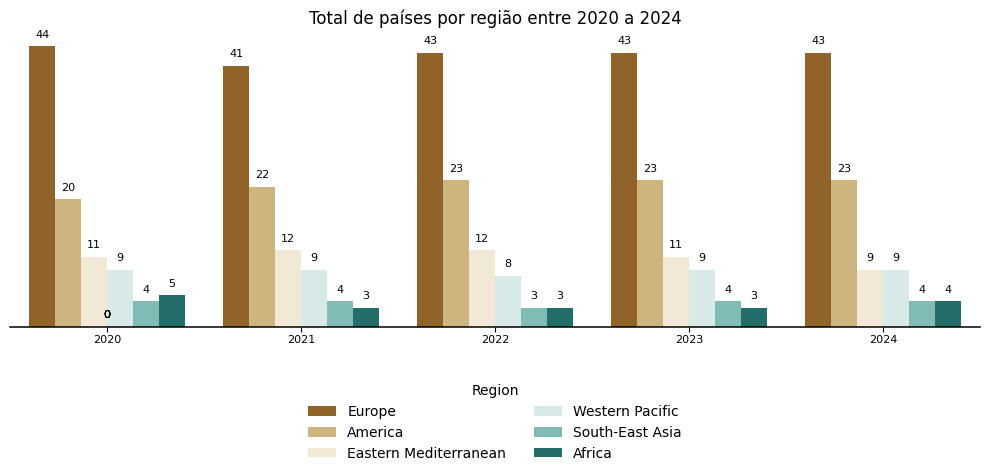

In [137]:
fig = plt.figure(figsize=(10, 5))

ax = sns.countplot(data=df_final, x='year', hue='region', palette='BrBG')

# Configurações dos espines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(1.1)

# Configura o eixo x
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=8)
ax.set_xlabel('', fontsize=10, labelpad=10)  # Sem rótulo no eixo x

# Configura o eixo y
ax.set_ylabel("", fontsize=10, labelpad=10)  # Sem rótulo no eixo y
ax.set_yticks([])  # Remove os ticks do eixo y

# Adiciona anotações para as barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Centraliza a anotação
                ha='center',
                va='bottom',
                size=8,
                xytext=(0, 5),
                textcoords='offset points')

# Configura a legenda
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, title='Region', fontsize=10)
# legend = ax.legend(loc='upper center',  bbox_to_anchor=(1.15, 1),  ncol=2, frameon=False, title='Região', fontsize=10 )

ax.set_title('Total de países por região entre 2020 a 2024')
plt.tight_layout()  # Ajusta o layout
plt.show()

## Development classification by IDH

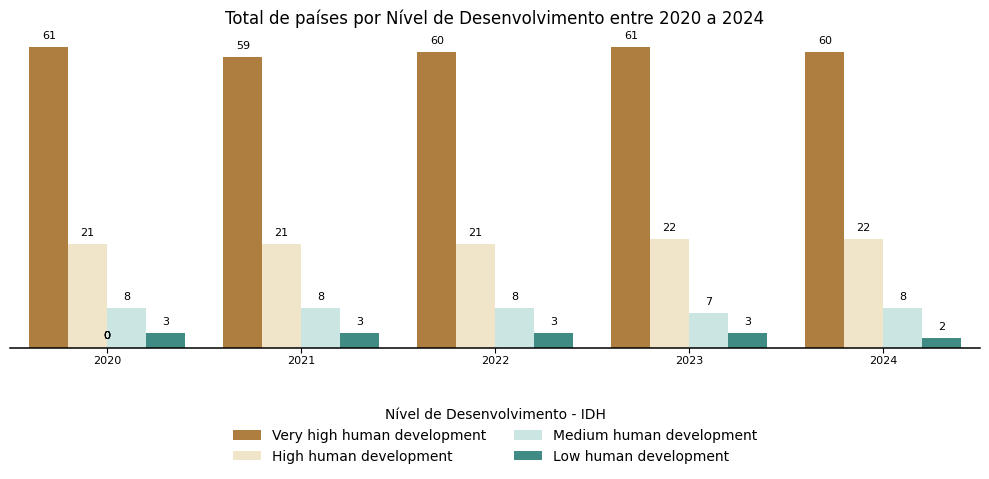

In [138]:
fig = plt.figure(figsize=(10, 5))

ax = sns.countplot(data=df_final, x='year', hue='development', palette='BrBG')

# Configurações dos espines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(1.1)

# Configura o eixo x
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=8)
ax.set_xlabel('', fontsize=10, labelpad=10)  # Sem rótulo no eixo x

# Configura o eixo y
ax.set_ylabel("", fontsize=10, labelpad=10)  # Sem rótulo no eixo y
ax.set_yticks([])  # Remove os ticks do eixo y

# Adiciona anotações para as barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Centraliza a anotação
                ha='center',
                va='bottom',
                size=8,
                xytext=(0, 5),
                textcoords='offset points')

# legend = ax.legend(loc='upper center',  bbox_to_anchor=(1.15, 1),  ncol=1, frameon=False, title='Nível de Desenvolvimento - IDH', fontsize=10 )
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, title='Nível de Desenvolvimento - IDH', fontsize=10)

ax.set_title('Total de países por Nível de Desenvolvimento entre 2020 a 2024')
plt.tight_layout()  # Ajusta o layout
plt.show()

## Development (IDH) per Region

In [139]:
# Ordenar por quantidade de países por região
idx_development = {
    'Very high human development':'1',
    'High human development':'2',
    'Medium human development':'3',
    'Low human development':'4'
}

df_chart = df_final[df_final['year'] == 2024].copy()
df_chart = df_chart[df_chart.development.isin(idx_development.keys())].copy()
df_chart['idx_development'] = df_chart.development.replace(idx_development).astype(int)
df_char = df_chart.sort_values(by = ['idx_development', 'idx_region'] )
df_chart = df_chart.groupby(['idx_development', 'development',  'idx_region', 'region']).size().reset_index(name='total')
df_chart = df_chart.sort_values(by = ['idx_development', 'idx_region'])



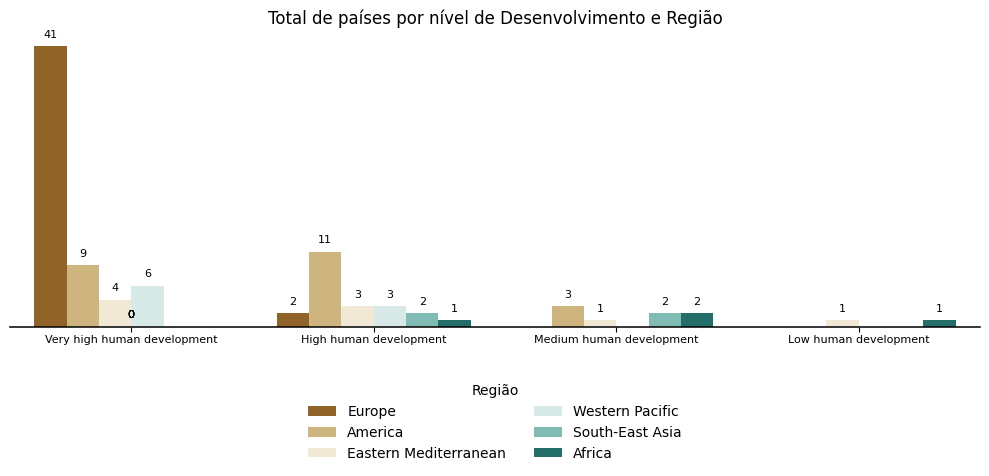

In [140]:
plt.figure(figsize=(10, 5))


ax = sns.barplot(data=df_chart, x='development', y='total', hue='region', palette='BrBG')

# Configurações dos espines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(1.1)

# Configura o eixo x
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=8)
ax.set_xlabel('', fontsize=10, labelpad=10)  # Sem rótulo no eixo x

# Configura o eixo y
ax.set_ylabel("", fontsize=10, labelpad=10)  # Sem rótulo no eixo y
ax.set_yticks([])  # Remove os ticks do eixo y

# Adiciona anotações para as barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Centraliza a anotação
                ha='center',
                va='bottom',
                size=8,
                xytext=(0, 5),
                textcoords='offset points')

# legend = ax.legend(loc='upper center',  bbox_to_anchor=(1, 0.8),  ncol=2, frameon=False, title='Region', fontsize=10)
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, title='Região', fontsize=10)


ax.set_title('Total de países por nível de Desenvolvimento e Região')
plt.tight_layout()  # Ajusta o layout
plt.show()



## Histogram

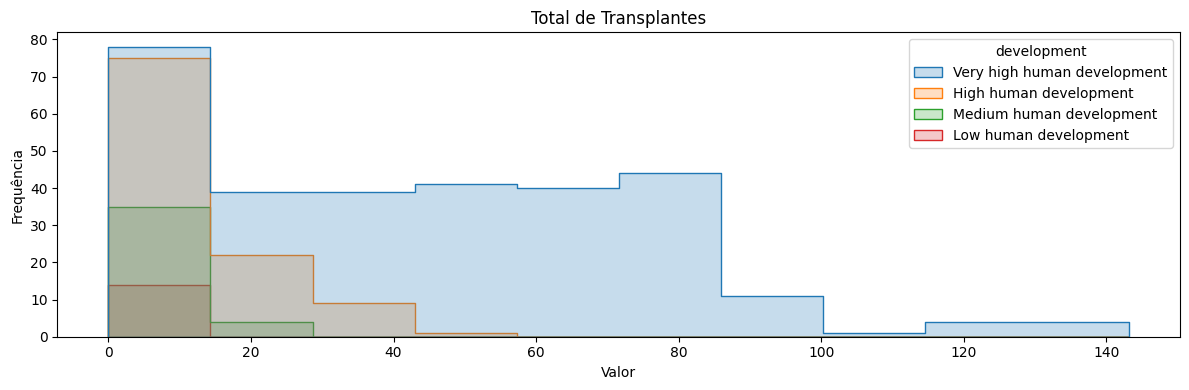

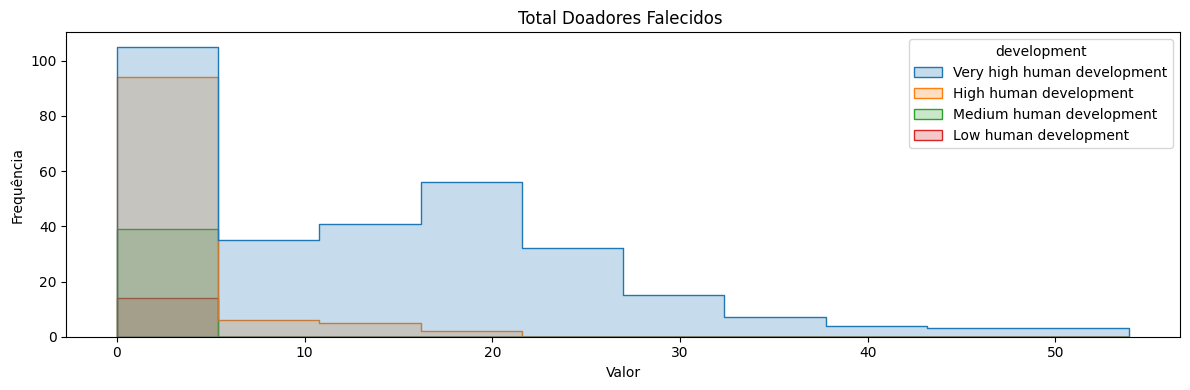

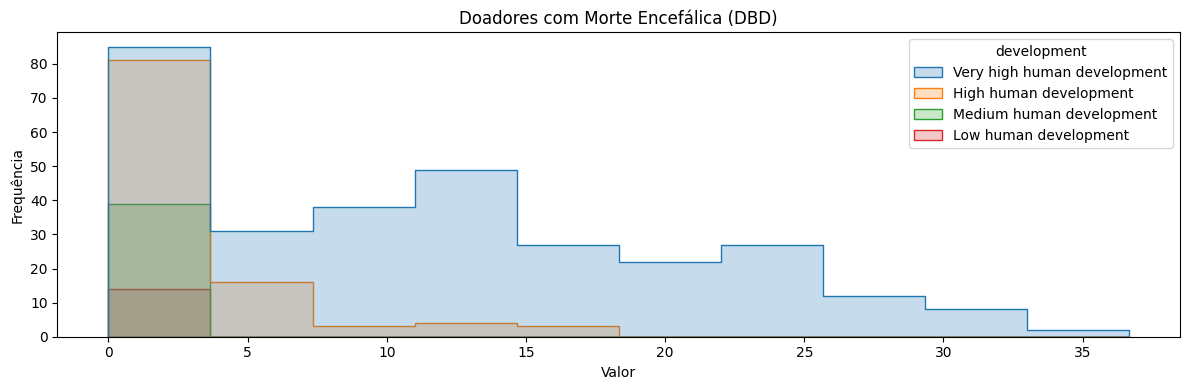

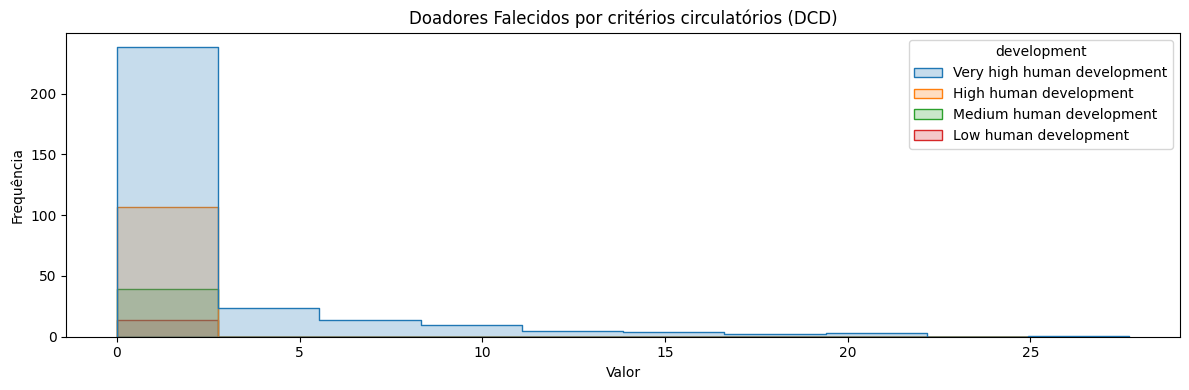

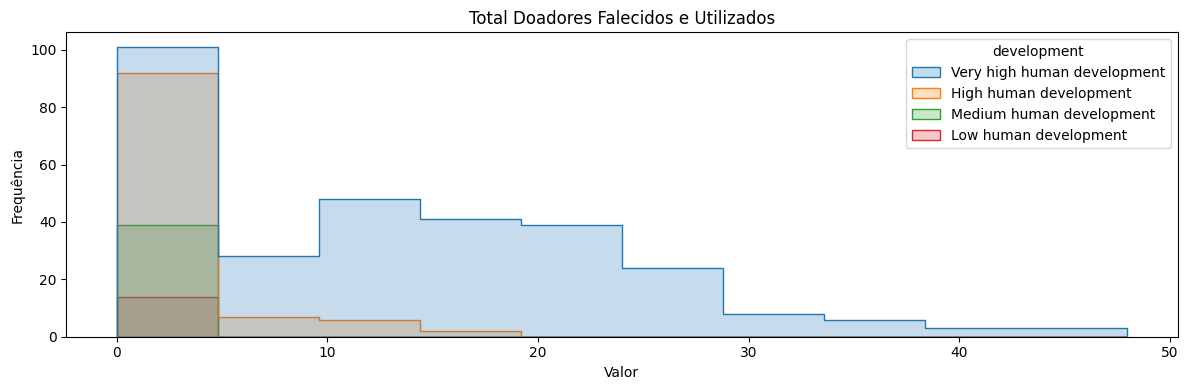

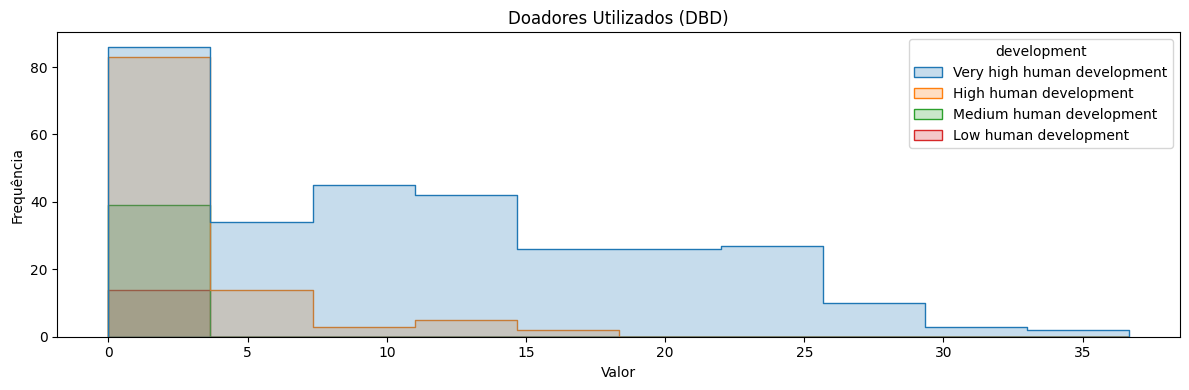

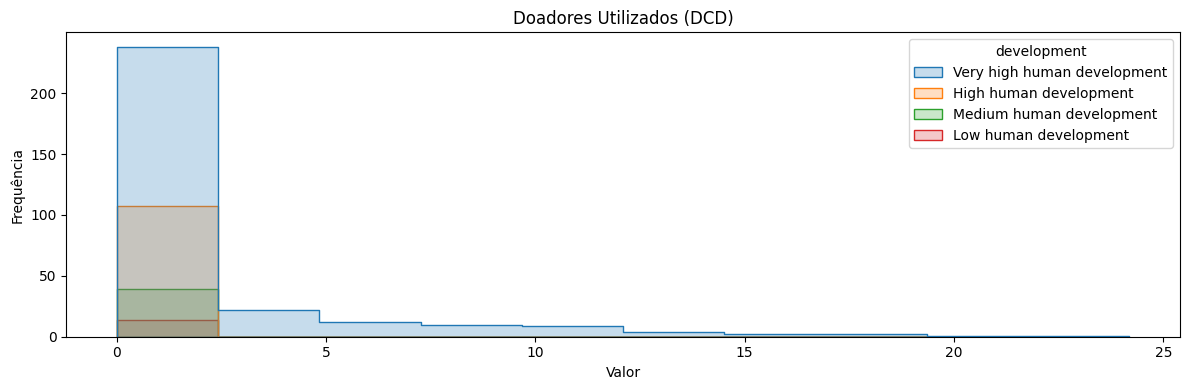

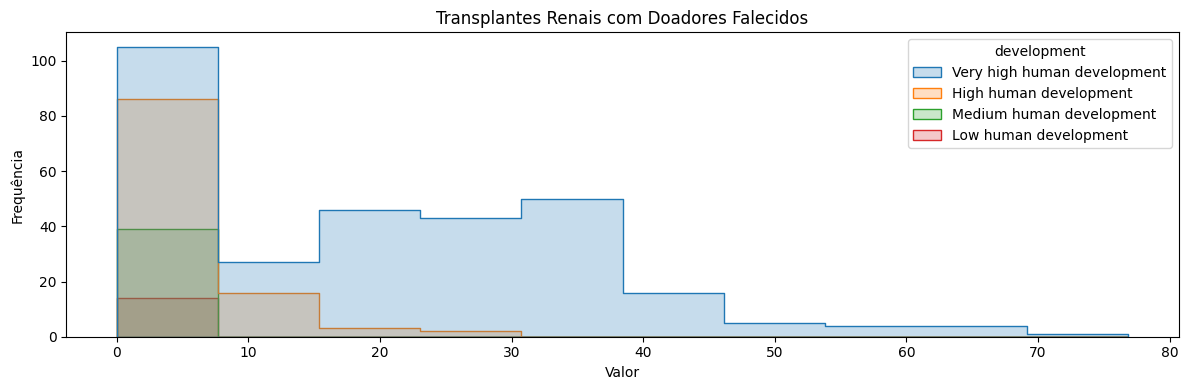

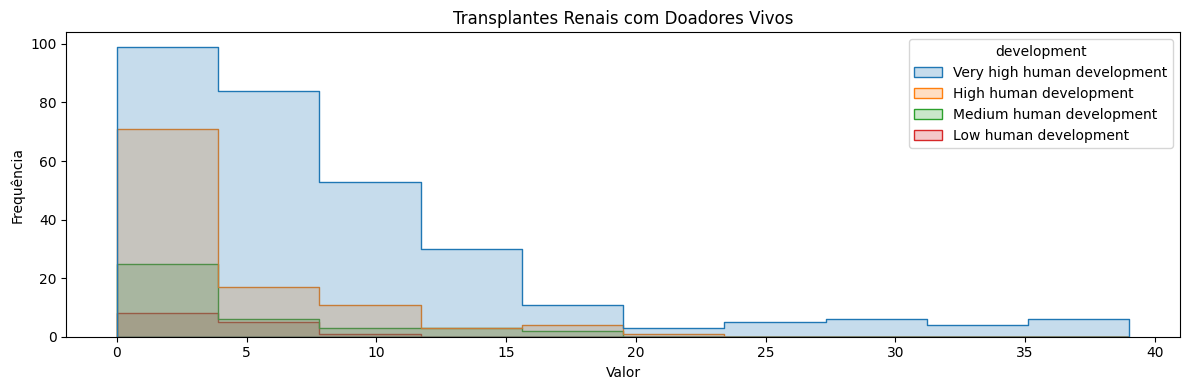

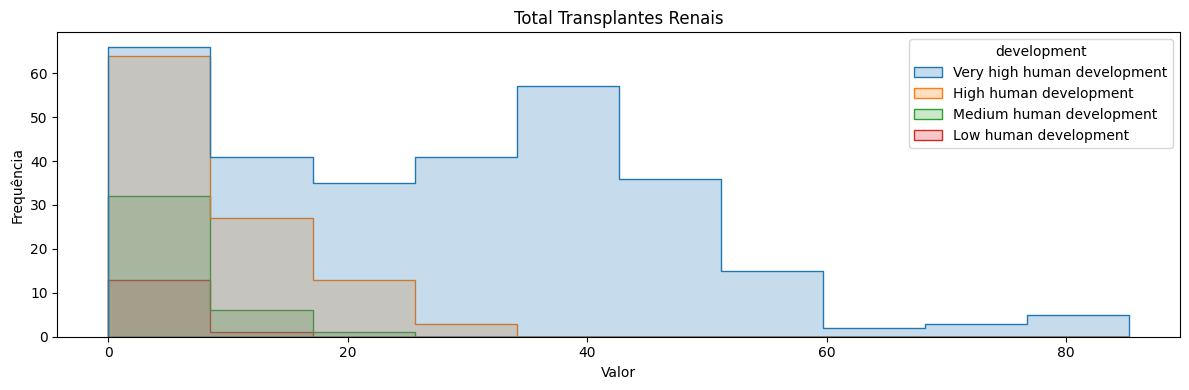

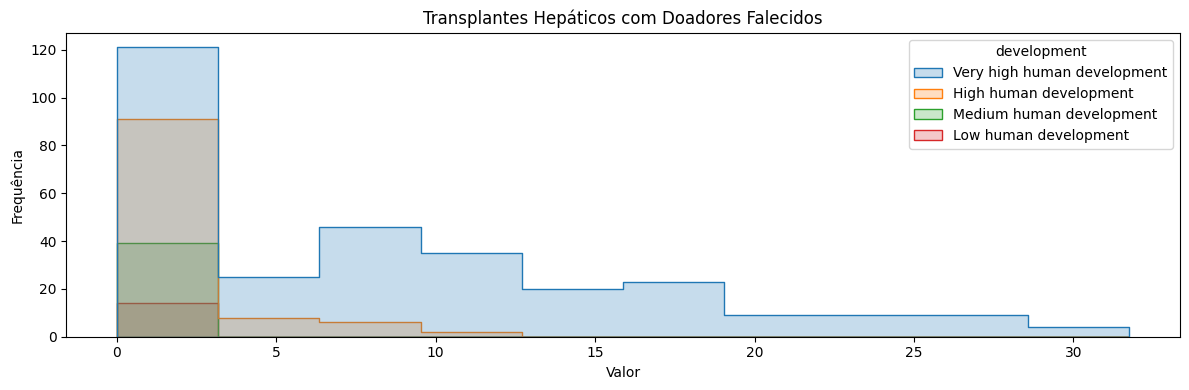

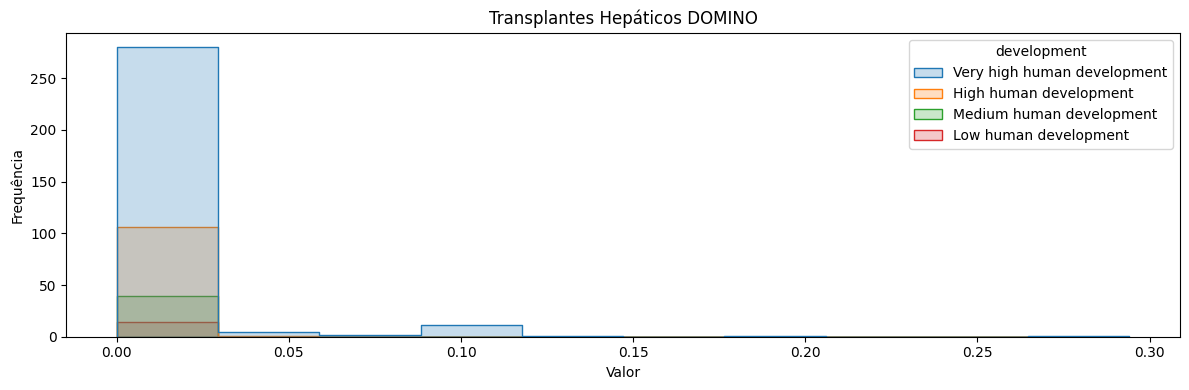

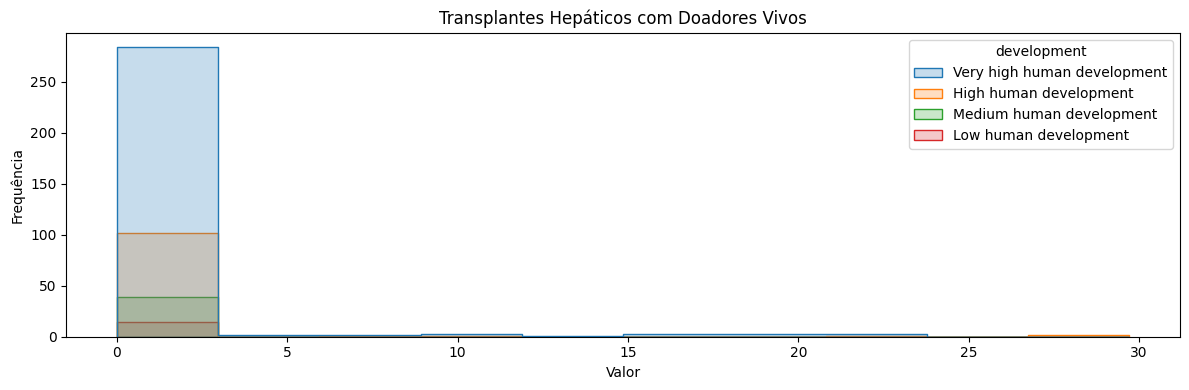

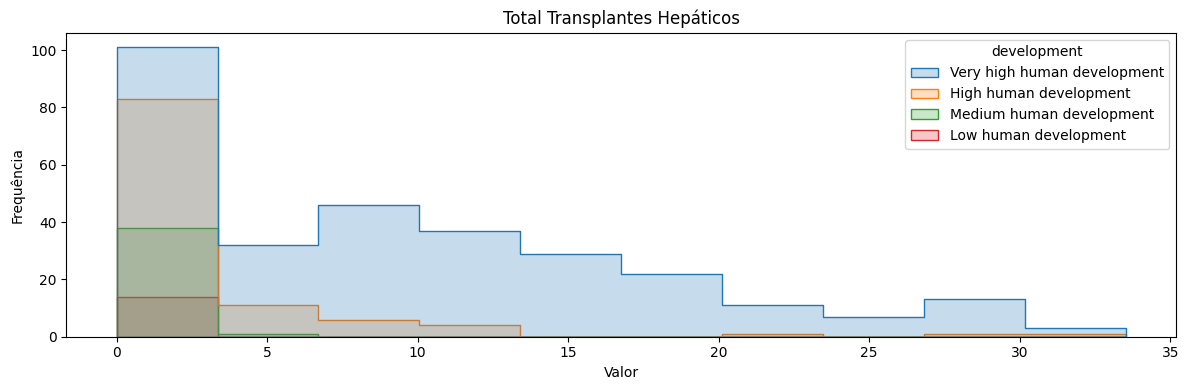

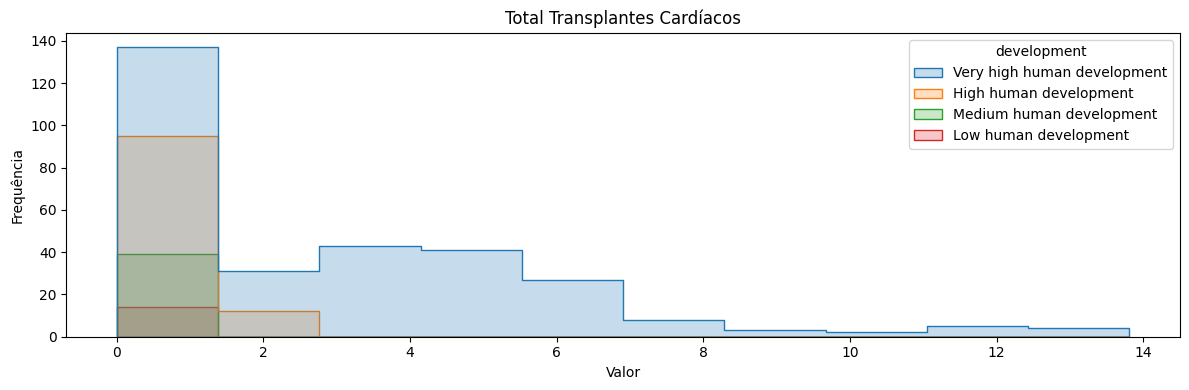

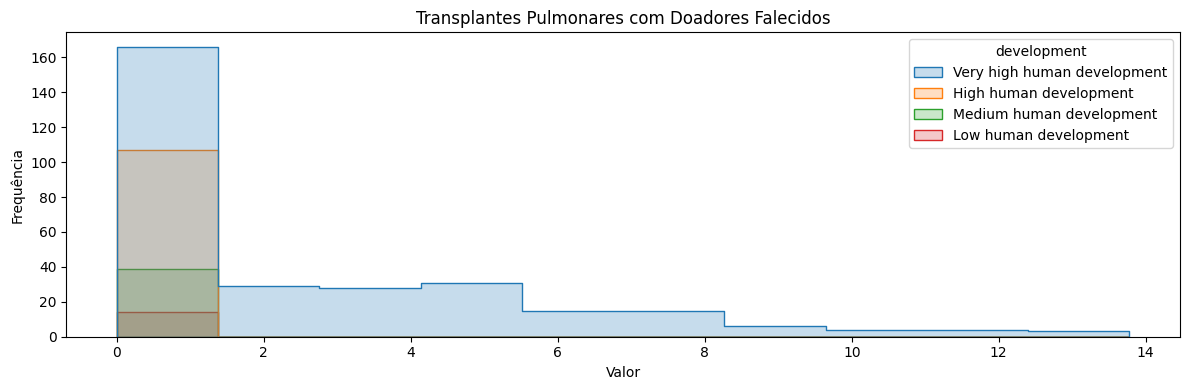

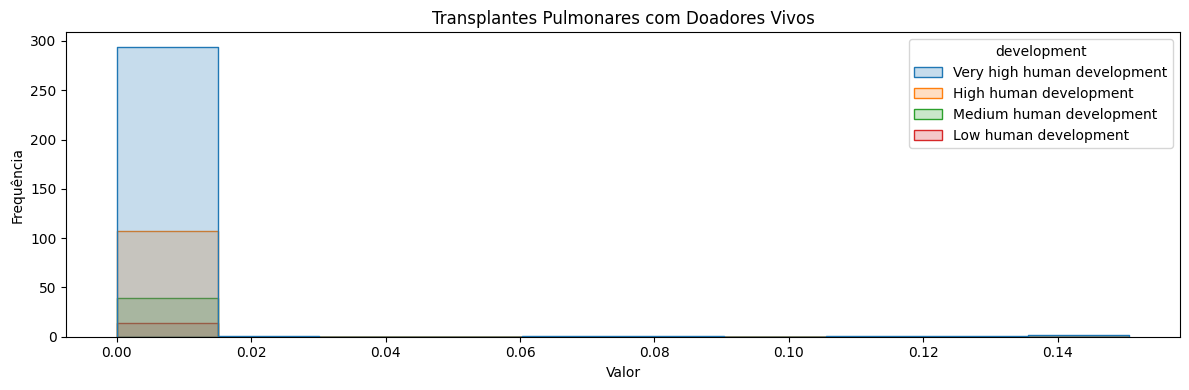

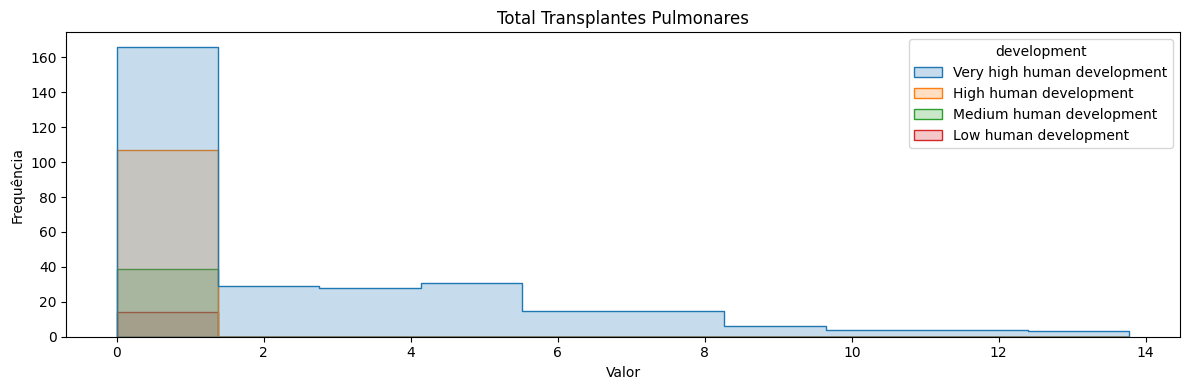

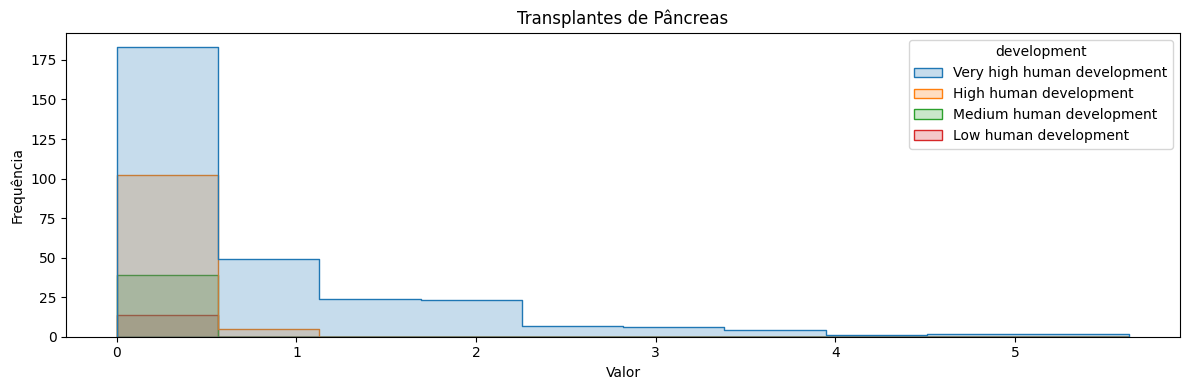

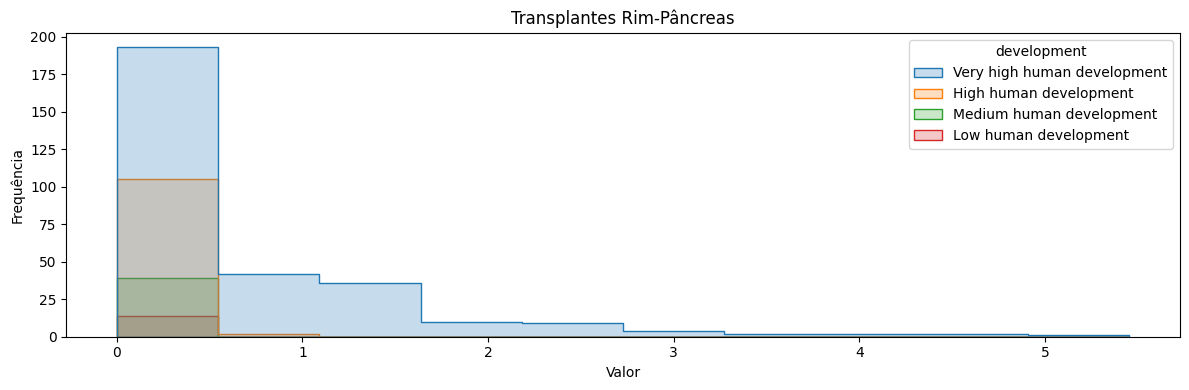

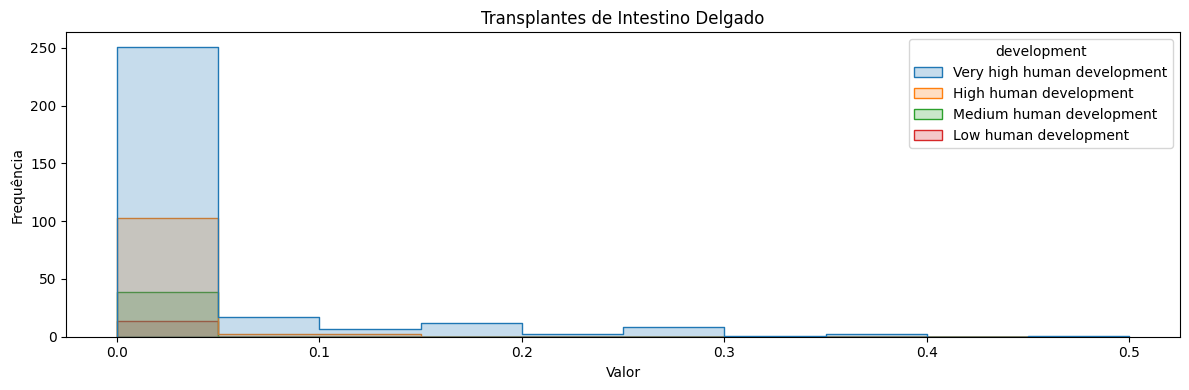

In [141]:
# Dicionário com títulos mais descritivos
titles_dict = {
    'pmp_TOTAL tx': 'Total de Transplantes',
    'pmp_TOTAL Actual DD': 'Total Doadores Falecidos ',
    'pmp_Actual DBD': 'Doadores com Morte Encefálica (DBD)',
    'pmp_Actual DCD': 'Doadores Falecidos por critérios circulatórios (DCD)',
    'pmp_Total Utilized DD': 'Total Doadores Falecidos e Utilizados',
    'pmp_Utilized DBD': 'Doadores Utilizados (DBD)',
    'pmp_Utilized DCD': 'Doadores Utilizados (DCD)',
    'pmp_DD Kidney Tx': 'Transplantes Renais com Doadores Falecidos',
    'pmp_LD Kidney Tx': 'Transplantes Renais com Doadores Vivos',
    'pmp_TOTAL Kidney Tx': 'Total Transplantes Renais',
    'pmp_DD Liver Tx': 'Transplantes Hepáticos com Doadores Falecidos',
    'pmp_DOMINO Liver Tx': 'Transplantes Hepáticos DOMINO',
    'pmp_LD Liver Tx': 'Transplantes Hepáticos com Doadores Vivos',
    'pmp_TOTAL Liver TX': 'Total Transplantes Hepáticos',
    'pmp_Total Heart TX': 'Total Transplantes Cardíacos',
    'pmp_DD Lung Tx': 'Transplantes Pulmonares com Doadores Falecidos',
    'pmp_LD Lung Tx': 'Transplantes Pulmonares com Doadores Vivos',
    'pmp_TOTAL Lung Tx': 'Total Transplantes Pulmonares',
    'pmp_Pancreas Tx': 'Transplantes de Pâncreas',
    'pmp_Kidney Pancreas Tx': 'Transplantes Rim-Pâncreas',
    'pmp_Small Bowel Tx': 'Transplantes de Intestino Delgado'
}

# Loop para gerar gráficos
for column in vars_pmp:
    plt.figure(figsize=(12, 4))
    ax = sns.histplot(data=df_final, x=column, hue="development", element='step', bins=10)

    # Usa o título do dicionário
    ax.set_title(titles_dict.get(column, column), fontsize=12)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência')

    # ax.legend(title='Nível de Desenvolvimento',  frameon=False)  # Novo nome da legenda

    plt.tight_layout()
    plt.show()

## Evolução ao longo do tempo

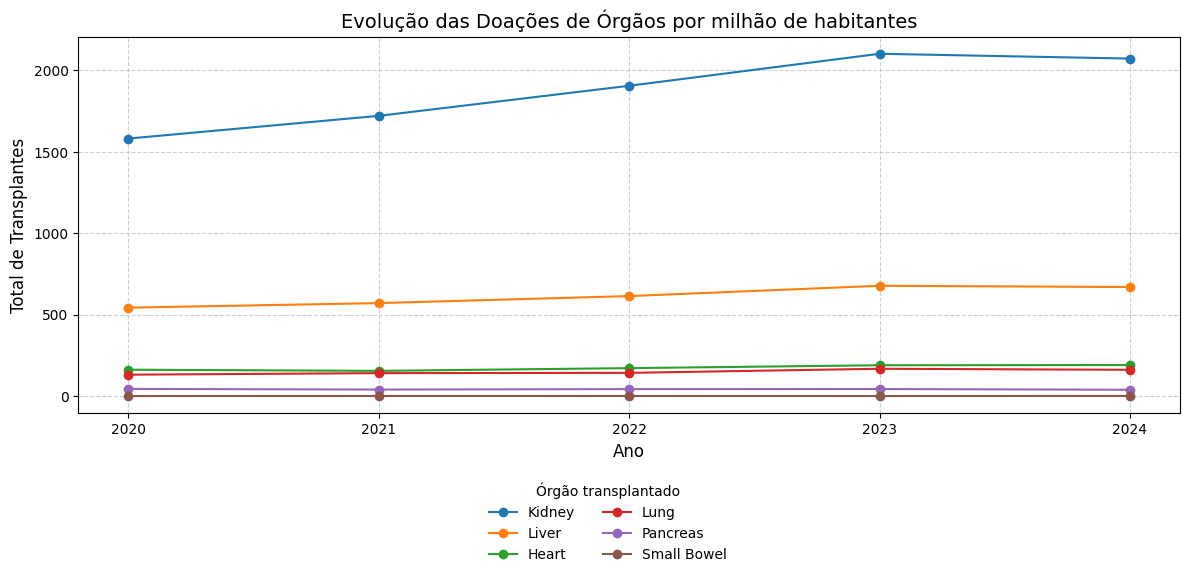

In [142]:
# Colunas originais
colunas = [
    'pmp_TOTAL Kidney Tx',
    'pmp_TOTAL Liver TX',
    'pmp_Total Heart TX',
    'pmp_TOTAL Lung Tx',
    'pmp_Pancreas Tx',
    'pmp_Small Bowel Tx'
]

# Dicionário para renomear
novo_nome = {
    'pmp_TOTAL Kidney Tx': 'Kidney',
    'pmp_TOTAL Liver TX': 'Liver',
    'pmp_Total Heart TX': 'Heart',
    'pmp_TOTAL Lung Tx': 'Lung',
    'pmp_Pancreas Tx': 'Pancreas',
    'pmp_Small Bowel Tx': 'Small Bowel'
}

# Agrupar por ano e somar
df_grouped = df_final.groupby('year')[colunas].sum().reset_index()
df_grouped['year'] = df_grouped['year'].astype(str)

# Renomear colunas
df_grouped.rename(columns=novo_nome, inplace=True)

# Atualizar lista de colunas para os novos nomes
colunas_renomeadas = list(novo_nome.values())

# Plotar
fig = plt.figure(figsize=(12, 6))

for coluna in colunas_renomeadas:
    plt.plot(df_grouped['year'], df_grouped[coluna], marker='o', label=coluna)

plt.title('Evolução das Doações de Órgãos por milhão de habitantes', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Total de Transplantes', fontsize=12)

plt.legend(title='Órgão transplantado', bbox_to_anchor=(0.6, -0.15), ncol=2, frameon=False, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Export

In [143]:
# df_final.head()

In [144]:
df_final.to_csv('df_transplants.csv', index=False, sep=';', decimal=',')

In [145]:
df_final.to_csv('df_transplants_v2.csv', index=False)

# Hierarchical clustering

In [146]:
import scipy
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy

In [147]:
def calcular_matriz_dissimilaridade(dados):
  M = np.zeros((len(dados),len(dados)))
  for i,row_i in dados.iterrows(): # para cada objeto i
      features_i = np.array(row_i) # atributos do objeto i
      for j,row_j in dados.iterrows(): # para cada objeto j
          features_j = np.array(row_j) # atributos do objeto j
          # calcula distância euclidiana
          euc = scipy.spatial.distance.euclidean(features_i, features_j)
          # armazena na posição M[i,j]
          M[i,j] = euc
  return M

## Com todos os anos e todas as variáveis

In [148]:
vars_hc = ['population', 'idh', 'pmp_TOTAL Actual DD', 'pmp_Total Utilized DD', 'pmp_DD Kidney Tx', 'pmp_LD Kidney Tx', 'pmp_TOTAL Kidney Tx', 'pmp_DD Liver Tx', 'pmp_DOMINO Liver Tx', 'pmp_LD Liver Tx',
           'pmp_TOTAL Liver TX', 'pmp_Total Heart TX', 'pmp_DD Lung Tx', 'pmp_LD Lung Tx', 'pmp_TOTAL Lung Tx', 'pmp_Pancreas Tx', 'pmp_Kidney Pancreas Tx', 'pmp_Small Bowel Tx']

df_hc = df_final[vars_hc].copy()

## Com todos os anos e somente algumas variáveis

In [149]:
vars_hc = ['population', 'idh', 'pmp_TOTAL Actual DD', 'pmp_Total Utilized DD', 'pmp_TOTAL Kidney Tx']
df_hc = df_final[vars_hc].copy()

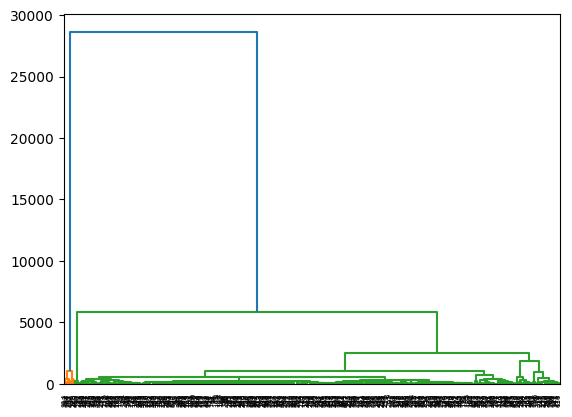

In [150]:
M_hc = calcular_matriz_dissimilaridade(df_hc)

Z_hc = hierarchy.linkage(M_hc, 'average')
dendrogram = hierarchy.dendrogram(Z_hc)

In [151]:
df_final['cluster_hc_average'] = hierarchy.cut_tree(Z_hc,n_clusters=4)

In [152]:
df_final['cluster_hc_average'].value_counts()

,count
cluster_hc_average,
0,405
1,41
2,10
3,5


## Somente 2023 e com algumas variáveis

In [153]:
vars_hc = ['population', 'pmp_TOTAL Actual DD', 'pmp_Total Utilized DD', 'pmp_TOTAL Kidney Tx',  'pmp_TOTAL Liver TX']

df_hc_2023 = df_final[df_final['year'] == 2023].copy().reset_index(drop=True)
df_hc = df_hc_2023[vars_hc].copy()

# Preencher NaN com zero
df_hc = df_hc.fillna(0)


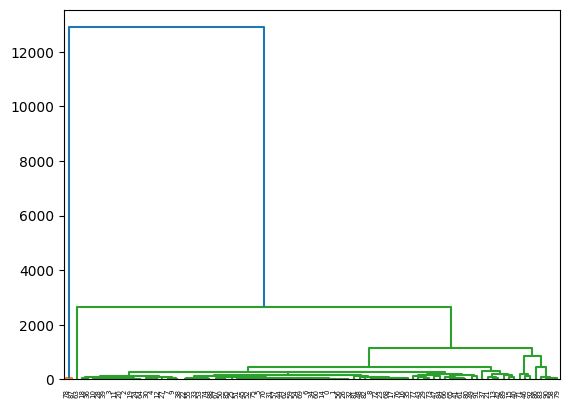

In [154]:
M_hc = calcular_matriz_dissimilaridade(df_hc)

Z_hc = hierarchy.linkage(M_hc, 'average')
dendrogram = hierarchy.dendrogram(Z_hc)

In [155]:
df_hc_2023['cluster_hc_average'] = hierarchy.cut_tree(Z_hc,n_clusters=4)

In [156]:
df_hc_2023['cluster_hc_average'].value_counts()

,count
cluster_hc_average,
0,82
1,8
3,2
2,1


## HC - Complete



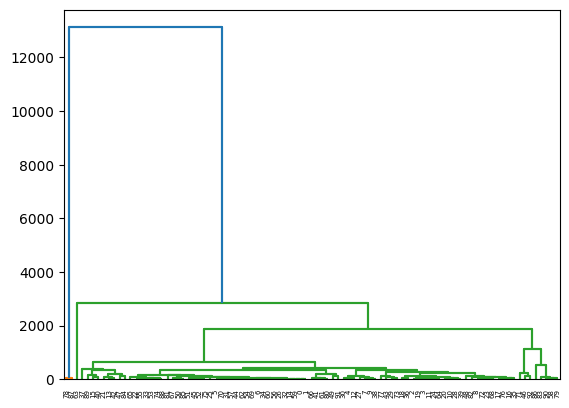

In [157]:
Z_hc2 = hierarchy.linkage(M_hc, 'complete')
dendrogram2 = hierarchy.dendrogram(Z_hc2)

M_hc2 = calcular_matriz_dissimilaridade(df_hc)

Z_hc2 = hierarchy.linkage(M_hc2, 'complete')
dendrogram2 = hierarchy.dendrogram(Z_hc2)

In [158]:
df_hc_2023['cluster_hc_complete'] = hierarchy.cut_tree(Z_hc2,n_clusters=4)

In [159]:
df_hc_2023['cluster_hc_complete'].value_counts()

,count
cluster_hc_complete,
0,82
1,8
3,2
2,1


In [160]:
df_final.to_csv('df_transplants_cluster.csv', index=False, sep=';', decimal=',')

In [161]:
df_hc_2023.to_csv('df_hc_2023.csv', index=False, sep=';', decimal=',')